In [2]:
import importlib
print('1')
import ESNClasses  # Import the module as an object
print('2')
importlib.reload(ESNClasses) #refresh
print('done')
from ESNClasses import *  #use the functions directly

1
2
done


**Load the data**

In [3]:
PAM1Path = 'data/PAM1_BifurcationData/PAM_timeseries_load_change.txt'
PAM1data = np.loadtxt(PAM1Path)

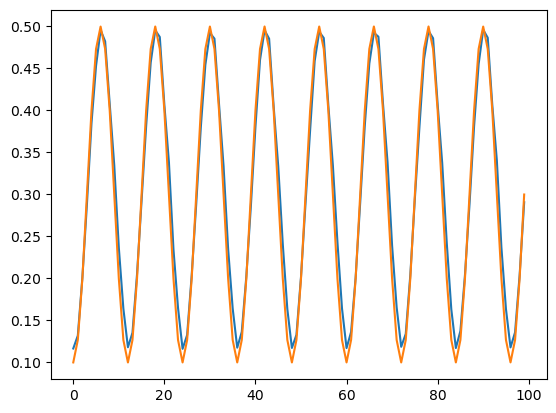

In [4]:
multiplexageResistance = [21]#3,9,21, 27] #15
multiplexagePressure = [7,13,25,31] #19
multiplexageLength = [4]#[4,10,22,28]#16
multiplexageLoadMeas = [6]#[6,12,24,30]#18
multiplexageMeasuredPressure = [23]#[5,11,23,29]#17
for load_val in range(150, 250, 5):
  for indexColumn in range(1):
    if(indexColumn>0):
        break

    start_index = int(((load_val - 100) / 5) * 2000)
    electricalResistance = PAM1data[start_index:(start_index + 2000), multiplexageResistance[indexColumn]] / 1e3
    pressure = PAM1data[start_index:(start_index + 2000), multiplexagePressure[indexColumn]]
    pressureMeas = PAM1data[start_index:(start_index + 2000), multiplexageMeasuredPressure[indexColumn]]
    length = PAM1data[start_index:(start_index + 2000), multiplexageLength[indexColumn]]
    load_meas = PAM1data[start_index:(start_index + 2000), multiplexageLoadMeas[indexColumn]]

    plt.plot(pressureMeas[:100])
    plt.plot(pressure[:100])
    plt.show()
  break


In [5]:
PAM2Path = 'data/PAM2_data/a_closedloop.txt'
PAM2data = np.loadtxt(PAM2Path)

In [6]:
# Dossier contenant vos .txt
base_dir = 'data/PAM3_RandomInputData'

# Dictionnaire pour stocker les données
data_dict = {}

# Chargement
for load in range(50, 251, 25):
    fname = f'PAM_step0.1_load{load}_20211224_edit.txt'
    path  = os.path.join(base_dir, fname)
    data = np.loadtxt(path)
    data_dict[load] = data


In [7]:
processed_data_dict = {}

for load, data in data_dict.items():
    n_rows, n_cols = data.shape
    assert n_cols == 32, f"Attendu 32 colonnes, trouvé {n_cols} pour load={load}"

    time_step = data[:, 0]
    rand_input = data[:, 1]
    mux_block = data[:, 2:].reshape(n_rows, 5, 6)

    grandeurs = ['R_meas', 'L_meas', 'P_meas', 'load_meas', 'P_ctrl', 'load_ctrl']
    multiplex_data = {}

    for m in range(5):
        mux_dict = {grandeurs[i]: mux_block[:, m, i] for i in range(6)}
        multiplex_data[f'mux_{m+1}'] = mux_dict

    processed_data_dict[load] = {
        'time_step': time_step,
        'rand_input': rand_input,
        'multiplex_data': multiplex_data
    }


In [8]:
def plot_variable(load, grandeur, timesteps = 100, mux='mux_1'):
    t = processed_data_dict[load]['time_step'][:timesteps]

    if grandeur == 'rand_input':
        y = processed_data_dict[load]['rand_input'][:timesteps]
    else:
        y = processed_data_dict[load]['multiplex_data'][mux][grandeur][:timesteps]

    plt.figure()
    plt.plot(t, y)
    plt.title(f'Load = {load}, {grandeur} ({mux if grandeur != "rand_input" else ""})')
    plt.xlabel('time_step')
    plt.ylabel(grandeur)
    plt.show()

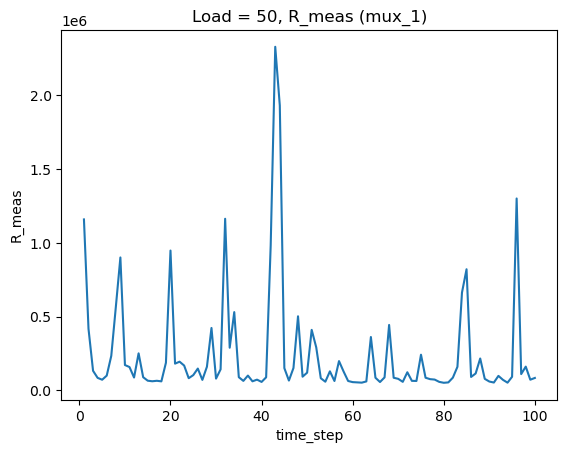

In [9]:
plot_variable(50, 'R_meas', 100,'mux_1')

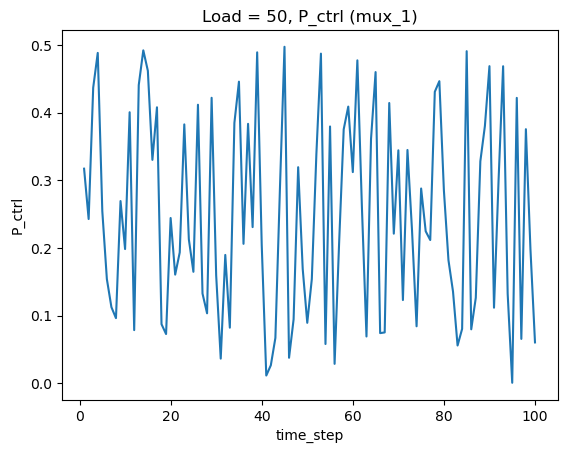

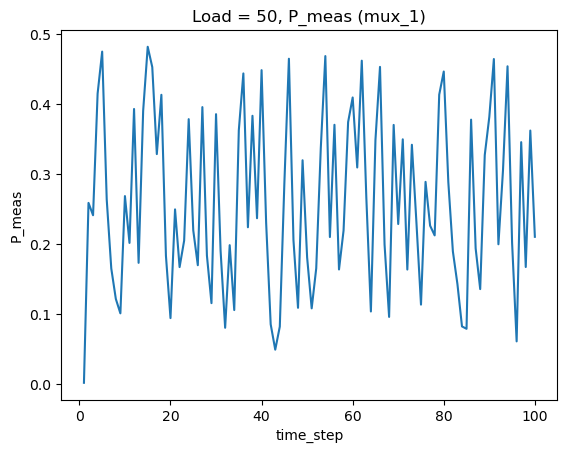

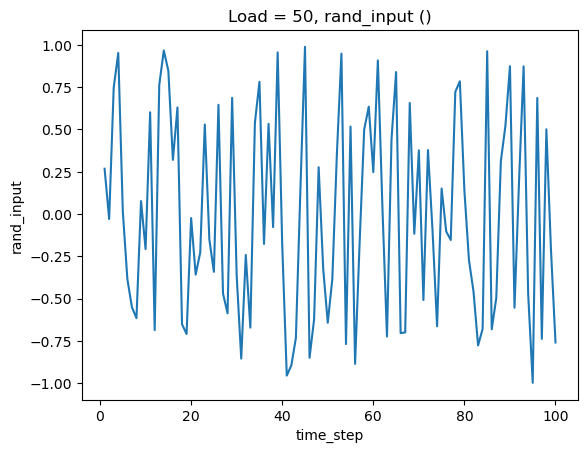

In [10]:
plot_variable(50, 'P_ctrl')
plot_variable(50,'P_meas')
plot_variable(50, 'rand_input')


In [11]:
def eval_esn_score(y_pred, y_target, alpha=0.8, eps=1e-8):
    # Normes
    nrse = np.linalg.norm(y_pred - y_target) / (np.linalg.norm(y_target) + eps)

    # Biais relatif (shift vertical)
    bias = np.abs(np.mean(y_pred - y_target)) / (np.mean(np.abs(y_target)) + eps)

    # Optionnel : squash pour rester < 1
    nrse_squash = nrse / (1 + nrse)
    bias_squash = bias / (1 + bias)

    # Score final : plus petit = meilleur
    score = alpha * nrse_squash + (1 - alpha) * bias_squash
    return score

def eval_esn_scoreOLDUNSUED(y_pred, y_target, alpha=0.5, eps=1e-8):
    errors = np.abs(y_pred - y_target)
    nrse_mean = np.mean(errors) / (np.mean(np.abs(y_target)) + eps)
    nrse_q = np.quantile(errors, 0.8) / (np.mean(np.abs(y_target)) + eps)
    return alpha * nrse_mean + (1 - alpha) * nrse_q



In [12]:
lambdasVals =[5] # Regularization parameter
rhoVals = [0.95]  # Spectral radius
leakyVals = [1]  # Leaky rate
sparsityVals = [1]  # Matrix sparsity
dimESNvals = [750,800,900,1000,1100,1150,1250,1300,1500]  # Size of the reservoir
sigma_output = 0.1  #Doesnt matter

winFactors = [1]
wnetFactors = [1]#1.4]


wpFactors = [0]


nbWashout = [20]
nbTrain = [200]

firstTrainingVals = [100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245]
#firstTrainingVals = [105,140,170,175,180,185,190,195,200,205,210,235,240,245]


betaValue = 0

inputScalings1 = [0.9]
reservoirScalings1 = [1]
biasScalings = [0.55]

inputScaling2 = 1
reservoirScaling2 = 1

washoutScaling = 0
theBiasesFactors = [1]
shrinkingFactors = [1]#0.4

dividersState = [1]

view100 = True
viewData = True

#General parameters
nbMeasures = 2000
deltaLoad = 5  # Newton
load_values = list(range(100, 255, deltaLoad))
num_points = 2000

t_predict = 200
heatTime = 25
t_predict = 200
heatTime = 25
shiftsTrain = [0]

deltaLoadRand = 25
nbMeasuresRand = 9999
deltaLoadSine = 5
nbMeasuresSine = 2000

load_values = list(range(100, 250, deltaLoad))
num_points = 2000

viewElec = False
viewLength = False
viewLoad = False
viewPressure = False

In [13]:
lambdasVals =[1] # Regularization parameter
rhoVals = [0.95]  # Spectral radius
leakyVals = [1]  # Leaky rate
sparsityVals = [1]  # Matrix sparsity
dimESNvals = [1000]  # Size of the reservoir
sigma_output = 0.1  #Doesnt matter

winFactors = [1]
wnetFactors = [1]#1.4]


wpFactors = [0]


nbWashout = [20]
nbTrain = [80]


#firstTrainingVals = [105,140,170,175,180,185,190,195,200,205,210,235,240,245]


betaValue = 0

inputScalings1 = [1]
reservoirScalings1 = [1]
biasScalings = [5]

inputScaling2 = 1
reservoirScaling2 = 1

washoutScaling = 0
theBiasesFactors = [1]
shrinkingFactors = [1]#0.4

dividersState = [1]

view100 = True
viewData = False

#General parameters
nbMeasures = 2000
deltaLoad = 5  # Newton
load_values = list(range(100, 255, deltaLoad))
num_points = 2000

t_predict = 200
heatTime = 25
t_predict = 200
heatTime = 25
shiftsTrain = [0]

viewElec = False
viewLength = True
viewLoad = False
viewPressure = False

firstTrainingVals = [50,75,100,125,150,175,200,225,250]
firstTrainingVals = [100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245]
showReservoirStates = True

second_param_lambda = 1

Rmax = 500
Rmin = 100
Pmax = 0.5
Pmin=0.1

In [14]:
def getTheData(load_value,type, mux):
    if (type == "rand"):
        start_index = int(((load_value - 50) / deltaLoadRand) * nbMeasuresRand)
        # Extraction of the  séries brutes
        electricalResistance = processed_data_dict[load_value]['multiplex_data'][f'mux_{mux+3}']['R_meas'] / 1e3
        pressure = processed_data_dict[load_value]['multiplex_data'][f'mux_{mux+1}']['P_ctrl']
        pressureMeas = processed_data_dict[load_value]['multiplex_data'][f'mux_{mux+3}']['P_meas']
        length = processed_data_dict[load_value]['multiplex_data'][f'mux_{mux+3}']['L_meas']
        load_meas = processed_data_dict[load_value]['multiplex_data'][f'mux_{mux+3}']['load_meas']

      #  loadVal = controlLoadTimeSeries[start_index : start_index+t_total]
       # length = lengthTimeSeries[start_index : start_index+t_total]

    else: #its a sine
        multiplexageResistance = [21]#3,9,21, 27] #15
        multiplexagePressure = [7,13,25,31] #19
        multiplexageLength = [22]#4,10,22,28]#16
        multiplexageLoadMeas = [24]#6,12,24,30]#18
        multiplexageMeasuredPressure = [23]#5,11,23,29]#17

        start_index = int(((load_value - 100) / deltaLoadSine) * nbMeasuresSine)
        electricalResistance = PAM1data[start_index:(start_index + nbMeasures), multiplexageResistance[indexColumn]] / 1e3
        pressure = PAM1data[start_index:(start_index + nbMeasures), multiplexagePressure[indexColumn]]
        pressureMeas = PAM1data[start_index:(start_index + nbMeasures), multiplexageMeasuredPressure[indexColumn]]
        length = PAM1data[start_index:(start_index + nbMeasures), multiplexageLength[indexColumn]]
        load_meas = PAM1data[start_index:(start_index + nbMeasures), multiplexageLoadMeas[indexColumn]]




    return electricalResistance,pressure,pressureMeas,length,load_meas

In [15]:
def normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining):
    # Définition des bornes et dimensions
    numeric_loads = [val for val, _ in loadTraining]
    loadValMin = min(100,np.min(numeric_loads))#100
    loadValMax =max(250,np.max(numeric_loads))#250

    # Normalization for the ESN
    electricalResistanceNormalized = (electricalResistance-np.min(electricalResistance))/(np.max(electricalResistance)-np.min(electricalResistance))
    pressureNormalized = (pressure-np.min(pressure))/(np.max(pressure)-np.min(pressure))
    pressureMeasNormalized = (pressureMeas-np.min(pressureMeas))/(np.max(pressureMeas)-np.min(pressureMeas))
    lengthNormalized = (length-np.min(length))/(np.max(length)-np.min(length))

    load_valNormalized = (load_val - loadValMin) / (loadValMax - loadValMin)

    return electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized


In [16]:
def plotTrainingResult(wout, x_train_ESN2, y_train_ESN2):
    n,m = y_train_ESN2.shape
    print(f"y_train_ESN2 shape: {np.array(y_train_ESN2).shape}")
    print(f"x_train_ESN2 shape: {np.array(x_train_ESN2).shape}")

    for i in range(m):
        plt.figure(figsize=(16, 4))
        plt.plot(y_train_ESN2[:,i])
        plt.plot(wout(x_train_ESN2)[:,i])
        plt.show()


In [17]:
#Boucles sur les hyperparamètres
results = []
stockScores = []
for param_lambda in lambdasVals:
    print("Lambda =", param_lambda)
    for theDivideState in dividersState:
        for rho in rhoVals:
            for matrix_sparsity in sparsityVals:
                for theshrinkingFactor in shrinkingFactors:
                    print("TheshrinkingFactor =", theshrinkingFactor)
                    for inputScaling1 in inputScalings1:
                        for reservoirScaling1 in reservoirScalings1:
                            for biasScaling in biasScalings:
                                for wnetVal in wnetFactors:
                                    for leaky_val in leakyVals:
                                        print("Leakage =", leaky_val)
                                     #for firstTrainingVal in firstTrainingVals:
                                        #print("first load train : ", firstTrainingVal)
                                        for winVal in winFactors:
                                            for dim_esn in dimESNvals:
                                                #  print("dimESN2 : ", dim_esn)
                                                for theBiasesFactor in theBiasesFactors:
                                                    for t_train in nbTrain:
                                                        # print("t_train : ", t_train)
                                                        for t_washout in nbWashout:
                                                            for shiftTrain in shiftsTrain :

                                                                params = {
                                                                    'lambda': param_lambda,
                                                                    'rho': rho,
                                                                    'sparsity': matrix_sparsity,
                                                                    'inputScaling': inputScaling1,
                                                                    'reservoirScaling': reservoirScaling1,
                                                                    'biasScaling': biasScaling,
                                                                    'leaky': leaky_val,
                                                                    'dim_esn': dim_esn,
                                                                    't_train': t_train,
                                                                    't_washout': t_washout
                                                                }

                                                                dictBifurcationValues = {}
                                                                dictBifurcationValues2 = {}


                                                                # ESN2 : transforme la prédiction normalisée de ESN1 en valeur brute.
                                                                # On choisit ici 2 entrées : [ESN1_prediction, load (brute)]
                                                                dim_in_ESN2 = 2
                                                                dim_out_ESN2 = 2

                                                                dim_in_ESN1 = 4
                                                                dim_out_ESN1 = 2

                                                                # Initialisation du générateur et conditions initiales
                                                                rnd = np.random.default_rng(1234)
                                                                reservoirScaling = 0
                                                                ###### Initialisation de l'ESN2 ######
                                                                x_init = rnd.uniform(low=-0, high=0, size=(dim_esn,))

                                                                w_inDilatation = Linear(dim_in_ESN2, dim_esn, bound=inputScaling1,
                                                                                        LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)

                                                                w_in1 = Linear(dim_in_ESN1, dim_esn, bound=inputScaling1,
                                                                                        LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)

                                                                netDilatation = ESN(
                                                                    dim=dim_esn,
                                                                    sr=rho,
                                                                    a=leaky_val,
                                                                    f=np.tanh,
                                                                    p=matrix_sparsity,
                                                                    init_state=x_init,
                                                                    rnd=rnd,
                                                                    normalize=True,
                                                                    wpFactor=0,
                                                                    wnetFactor=wnetVal,
                                                                    knet=reservoirScaling1,
                                                                    kbias = biasScaling,
                                                                    theBiasFactor = theBiasesFactor,
                                                                    shrinkingFactor = theshrinkingFactor,
                                                                    divideStates = theDivideState
                                                                )
                                                                w_outDilation = RidgeReadout(dim_esn, dim_out_ESN2, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=param_lambda, rnd=rnd)

                                                                w_out2 = RidgeReadout(dim_esn, dim_out_ESN1, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=second_param_lambda, rnd=rnd)


                                                                loadTraining = [(75,'rand'), (100,'rand'), (250,'rand'),(155,'sine'), (220,'sine')]#(50,'rand'),(175,'rand'), (225,'rand'), (160,'sine'), (220,'sine')]


                                                                # Définition des bornes et dimensions
                                                                numeric_loads = [val for val, _ in loadTraining]
                                                                loadValMin = min(100,np.min(numeric_loads))#100
                                                                loadValMax =max(250,np.max(numeric_loads))#250

                                                                t_total = t_washout + t_train

                                                                ######################################################################
                                                                #TRAINING FIRST ESN
                                                                ######################################################################
                                                                x_train_ESN2 = []
                                                                y_train_ESN2 = []

                                                                numberOfMultiplexage =1#5

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                      inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                      inputReservoir = w_inDilatation(inputWashout, beta=0, winFactor=winVal)
                                                                      netDilatation.step(inputReservoir, p =0)

                                                                    for t in range(shiftTrain, shiftTrain+t_train):
                                                                      t_actual = t
                                                                      current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                            load_valNormalized]

                                                                      inputReservoir = w_inDilatation(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                      netDilatation.step(inputReservoir, p=0)

                                                                      if t_actual>=heatTime: #Phase de "chauffe" des états du réservoir
                                                                        x_train_ESN2.append(np.copy(netDilatation.x)) #reservoir states
                                                                        y_train_ESN2.append([electricalResistance[t_actual],  pressureMeas[t_actual]])

                                                                x_train_ESN2 = np.array(x_train_ESN2)
                                                                y_train_ESN2 = np.array(y_train_ESN2)

                                                                w_outDilation.train(x_train_ESN2, y_train_ESN2)

                                                                plotTrainingResult(x_train_ESN2, y_train_ESN2)

                                                                ##################################
                                                                # TRAINING OF THE SECOND READOUT #
                                                                ##################################

                                                                x_train_ESN2 = []
                                                                y_train_ESN2 = []

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        netDilatation.step(w_inDilatation(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_inDilatation(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        netDilatation.step(in_2, p=0)

                                                                        y_out2 = w_outDilation(np.copy(netDilatation.x))[0][0]
                                                                        y_out1 = w_outDilation(np.copy(netDilatation.x))[0][1]

                                                                        predictedElec = y_out2
                                                                        predictedPressure = y_out1

                                                                        inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if(t>=heatTime):
                                                                            current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                                  inputElecESN,
                                                                                                  inputPressureESN,
                                                                                                  load_valNormalized]


                                                                            inputReservoir = w_in1(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                            netDilatation.step(inputReservoir, p=0)

                                                                            x_train_ESN2.append(np.copy(netDilatation.x)) #reservoir states
                                                                            y_train_ESN2.append([length[t_actual], load_meas[t_actual]])

                                                                x_train_ESN2 = np.array(x_train_ESN2)
                                                                y_train_ESN2 = np.array(y_train_ESN2)

                                                                w_out2.train(x_train_ESN2, y_train_ESN2)

                                                                plotTrainingResult(x_train_ESN2, y_train_ESN2)

                                                                #############################################################
                                                                # Phase de prédiction en chaîne pour les 2 readouts #
                                                                #############################################################
                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresRandom = []

                                                                for load_val in range(50, 251, 25):
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value=load_val,type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)


                                                                    # Predictions ESN
                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    oneReservoir2StateValue = []
                                                                    cpt = 0


                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        netDilatation.step(w_inDilatation(inputWashout, beta=0, winFactor=winVal), p =0)
                                                                        oneReservoir2StateValue.append(netDilatation.x[80:90].copy())


                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                          oneReservoir2StateValue.append(netDilatation.x[80:90].copy())

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_inDilatation(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        netDilatation.step(in_2, p=0)

                                                                        y_out2 = w_outDilation(np.copy(netDilatation.x))[0][0]
                                                                        y_out1 = w_outDilation(np.copy(netDilatation.x))[0][1]

                                                                        predictedElec = y_out2
                                                                        predictedPressure = y_out1

                                                                        inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out2
                                                                          y_pred_pressure[t_actual-heatTime] = y_out1

                                                                          current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                                  inputElecESN,
                                                                                                  inputPressureESN,
                                                                                                  load_valNormalized]


                                                                          in_2 = w_in1(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                          netDilatation.step(in_2, p=0)

                                                                          y_out3 = w_out2(np.copy(netDilatation.x))[0][0]
                                                                          y_out4 = w_out2(np.copy(netDilatation.x))[0][1]


                                                                          y_pred_pressure[t_actual-heatTime] = y_out3
                                                                          y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    #SCORE :
                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    scoresRandom.append(batch_score)

                                                                    title_str = (f"load = {load_val}, λ={param_lambda}, ρ={rho}, p={matrix_sparsity}\n"
                                                                                 f"a={leaky_val}, β={betaValue}\n"
                                                                                 f"wnet={wnetVal}, win={winVal}\n"
                                                                                 f"dim_esn={dim_esn}, t_train={t_train}, t_washout={t_washout}")

                                                                    if (viewElec and ((load_val == 50) or (load_val == 110) or (load_val == 200)) and indexColumn == 0):

                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLength and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLoad):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()


                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                finalScoreRandom = np.mean(scoresRandom)
                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)

                                                                #SECOND TEST DATAS FOR SINE INPUT
                                                                dictBifurcationValues = {}

                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresSine = []

                                                                for load_val in range(100, 251, 5):
                                                                  for indexColumn in range(numberOfMultiplexage):
                                                                    if(indexColumn>0):
                                                                        break

                                                                    start_index = int(((load_val - 100) / deltaLoadSine) * nbMeasuresSine)
                                                                    electricalResistance = PAM1data[start_index:(start_index + nbMeasures), multiplexageResistance[indexColumn]] / 1e3
                                                                    pressure = PAM1data[start_index:(start_index + nbMeasures), multiplexagePressure[indexColumn]]
                                                                    pressureMeas = PAM1data[start_index:(start_index + nbMeasures), multiplexageMeasuredPressure[indexColumn]]
                                                                    length = PAM1data[start_index:(start_index + nbMeasures), multiplexageLength[indexColumn]]
                                                                    load_meas = PAM1data[start_index:(start_index + nbMeasures), multiplexageLoadMeas[indexColumn]]


                                                                    # Normalization for ESN
                                                                    electricalResistanceNormalized = (electricalResistance-np.min(electricalResistance))/(np.max(electricalResistance)-np.min(electricalResistance))
                                                                    pressureNormalized = (pressure-np.min(pressure))/(np.max(pressure)-np.min(pressure))
                                                                    pressureMeasNormalized = (pressureMeas-np.min(pressureMeas))/(np.max(pressureMeas)-np.min(pressureMeas))
                                                                    lengthNormalized = (length-np.min(length))/(np.max(length)-np.min(length))

                                                                    load_valNormalized = (load_val - loadValMin) / (loadValMax - loadValMin)


                                                                    # Predictions ESN

                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    oneReservoir2StateValue = []
                                                                    cpt = 0


                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        netDilatation.step(w_inDilatation(inputWashout, beta=0, winFactor=winVal), p =0)
                                                                        oneReservoir2StateValue.append(netDilatation.x[80:90].copy())


                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                          oneReservoir2StateValue.append(netDilatation.x[80:90].copy())

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_inDilatation(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        netDilatation.step(in_2, p=0)

                                                                        y_out2 = w_outDilation(np.copy(netDilatation.x))[0][0]
                                                                        y_out1 = w_outDilation(np.copy(netDilatation.x))[0][1]

                                                                        predictedElec = y_out2
                                                                        predictedPressure = y_out1

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out2
                                                                          y_pred_pressure[t_actual-heatTime] = y_out1

                                                                          current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                                  predictedElec,
                                                                                                  predictedPressure,
                                                                                                  load_valNormalized]


                                                                          in_2 = w_in1(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                          netDilatation.step(in_2, p=0)

                                                                          y_out3 = w_out2(np.copy(netDilatation.x))[0][0]
                                                                          y_out4 = w_out2(np.copy(netDilatation.x))[0][1]


                                                                          y_pred_pressure[t_actual-heatTime] = y_out3
                                                                          y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    scoresSine.append(batch_score)

                                                                    dictBifurcationValues = createMyBifurcationDiagram(y_pred_elec, dictBifurcationValues, load_val)

                                                                    title_str = (f"load = {load_val}, λ={param_lambda}, ρ={rho}, p={matrix_sparsity}\n"
                                                                                 f"a={leaky_val}, β={betaValue}\n"
                                                                                 f"wnet={wnetVal}, win={winVal}\n"
                                                                                 f"dim_esn={dim_esn}, t_train={t_train}, t_washout={t_washout}")


                                                                     # --- Bloc corrigé pour tracer une seule figure fixe par load_val ---
                                                                    if (viewElec and ((load_val == 50) or (load_val == 110) or (load_val == 200)) and indexColumn == 0):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLength and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLoad):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                finalScoreSine = np.mean(scoresSine)

                                                                # Stockage des résultats
                                                                results.append((params, finalScoreRandom, finalScoreSine))
                                                                stockScores.append((finalScoreRandom, finalScoreSine))

                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)


                                                                fig, ax = plt.subplots(figsize=(10, 6))


                                                                plotBifurcation(dictBifurcationValues, ax = ax)

                                                                multiplexage_columns = multiplexageResistance

                                                                colors = ['red']* len(multiplexage_columns)
                                                                labels = ['Target']#Multiplexage {col}' for col in multiplexage_columns]


                                                                # On suppose que 'data' est déjà défini (ex. un array numpy contenant vos données)
                                                                #plot_target_bifurcation(ax, data, multiplexage_columns, load_values, nbMeasures, deltaLoad, num_points, colors, labels)

                                                                plot_target_bifurcation(
                                                                    ax,
                                                                    PAM1data,
                                                                    multiplexage_columns,
                                                                    load_values,
                                                                    nbMeasures,
                                                                    deltaLoad,
                                                                    num_points
                                                                )

                                                                from matplotlib.lines import Line2D

                                                                legend_elements = [
                                                                    Line2D([0], [0], marker='o', color='w', label='Prediction',
                                                                           markerfacecolor='blue', markersize=6),
                                                                    Line2D([0], [0], marker='o', color='w', label='Target',
                                                                           markerfacecolor='red', markersize=6)
                                                                ]
                                                                ax.legend(handles=legend_elements)

                                                                # Configuration finale du plot
                                                                ax.set_xlabel('Bifurcation parameter, Load [N]')
                                                                ax.set_ylabel('Resistance [kOhm]')

                                                                plt.tight_layout()
                                                                plt.show()






Lambda = 1
TheshrinkingFactor = 1
Leakage = 1


TypeError: plotTrainingResult() missing 1 required positional argument: 'y_train_ESN2'

***PREDICT ELEC, PRESSURE, LENGTH WITH 2 ESN, LOAD is BADLY PREDICTED***

In [1]:
lambdasVals =[1] # Regularization parameter
rhoVals = [0.95]  # Spectral radius
leakyVals = [1]  # Leaky rate
sparsityVals = [1]  # Matrix sparsity
dimESNvals = [1000]  # Size of the reservoir
sigma_output = 0.1  #Doesnt matter

winFactors = [1]
wnetFactors = [1]#1.4]


wpFactors = [0]


nbWashout = [20]
nbTrain = [65]


#firstTrainingVals = [105,140,170,175,180,185,190,195,200,205,210,235,240,245]


betaValue = 0

inputScalings1 = [1.25]
reservoirScalings1 = [1]
biasScalings = [1.75]

inputScaling2 = 1
reservoirScaling2 = 1

washoutScaling = 0
theBiasesFactors = [1]
shrinkingFactors = [1]#0.4

dividersState = [1]

view100 = True
viewData = False

#General parameters
nbMeasures = 2000
deltaLoad = 5  # Newton
load_values = list(range(100, 255, deltaLoad))
num_points = 2000

t_predict = 200
heatTime = 25
t_predict = 200
heatTime = 25
shiftsTrain = [0]

viewElec = False
viewLength = True
viewLoad = False
viewPressure = True

firstTrainingVals = [100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245]
firstTrainingVals = [20,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245]


firstTrainingVals = [50,75,100,125,150,175,200,225,250]



showReservoirStates = True

second_param_lambda = 1

Rmax = 500
Rmin = 100
Pmax = 0.5
Pmin=0.1

Lambda = 1
TheshrinkingFactor = 1
Leakage = 1
first load train :  50
y_train_ESN2 shape: (160, 2)
x_train_ESN2 shape: (160, 1000)


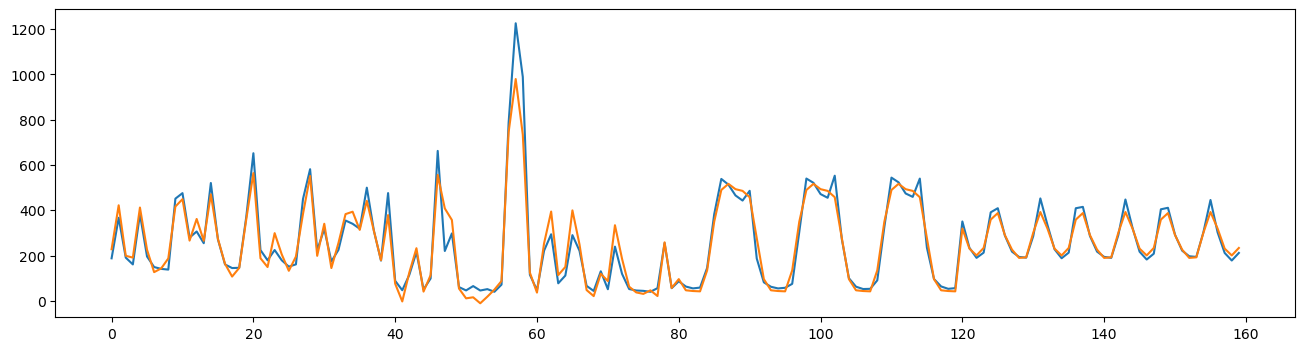

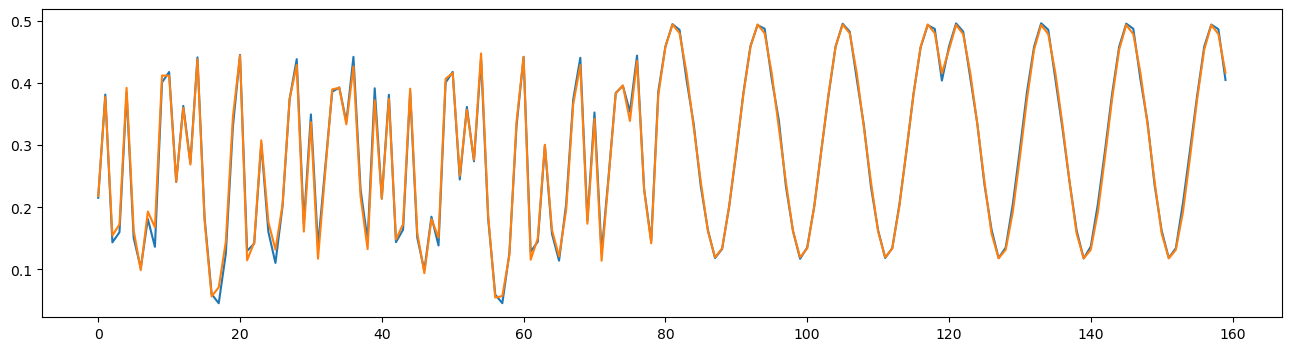

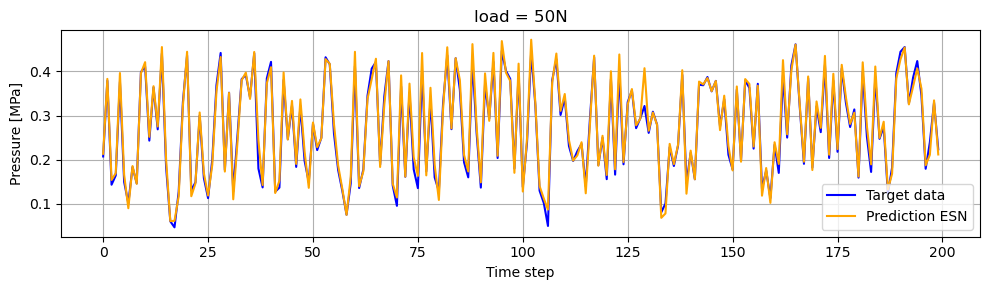

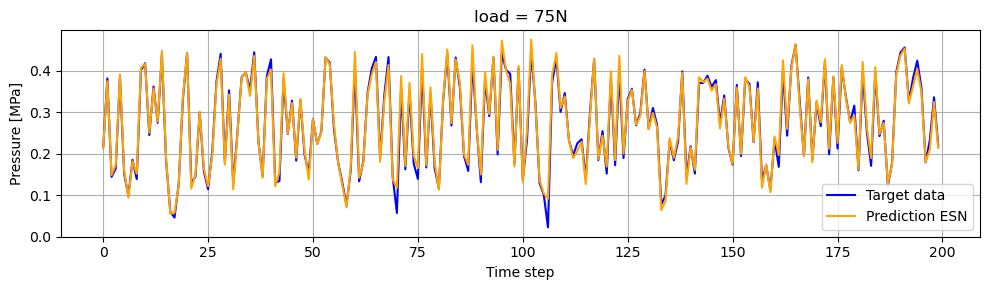

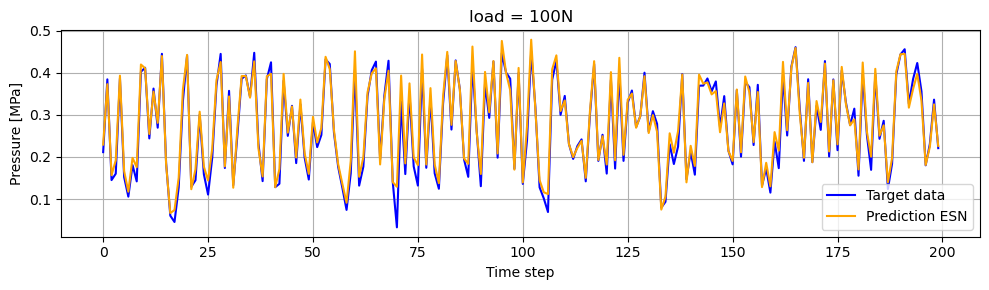

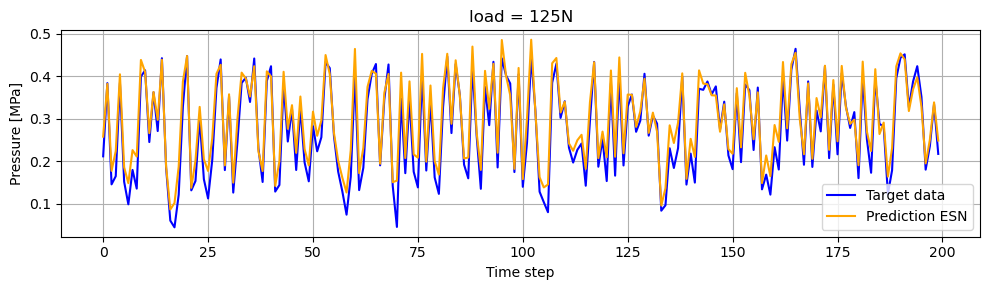

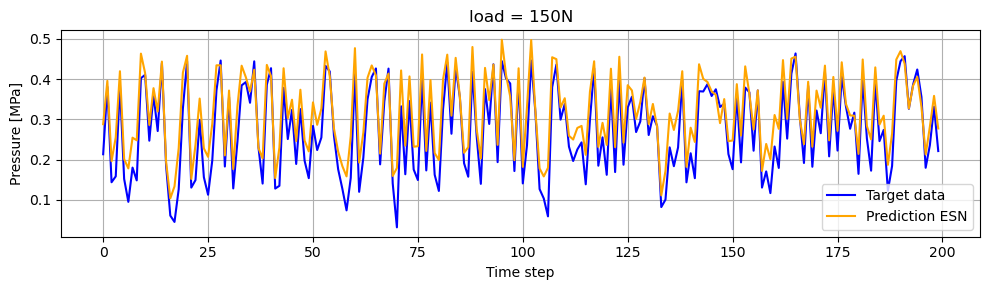

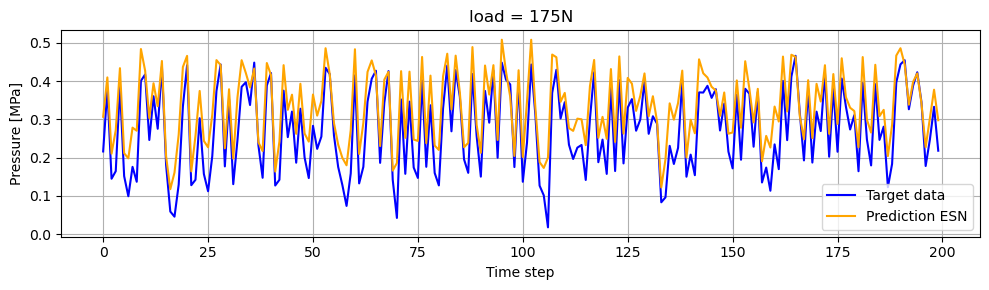

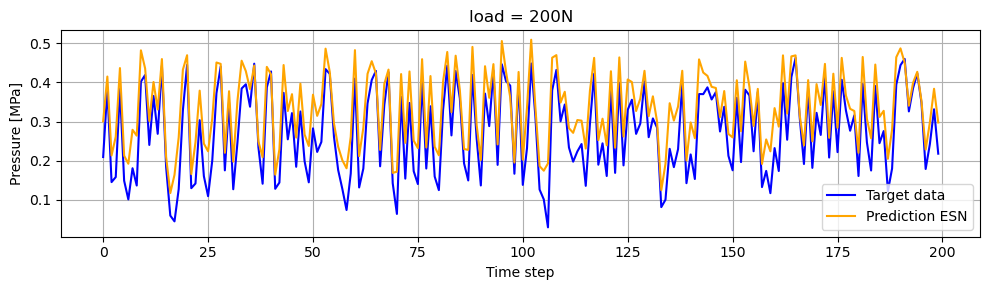

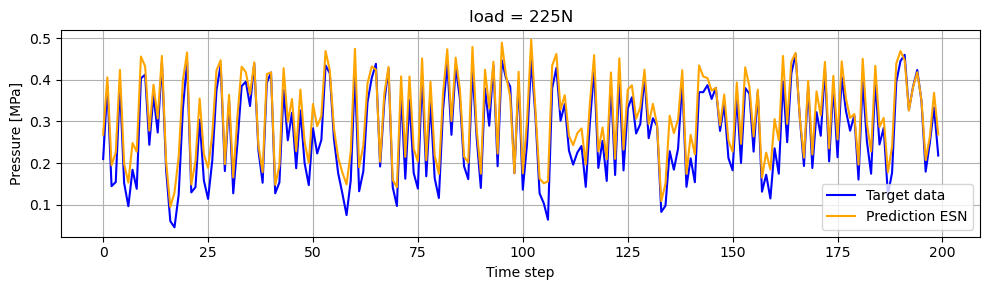

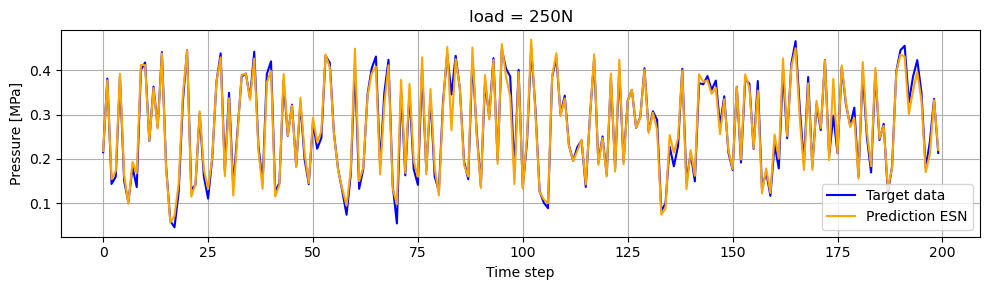

In [ ]:
#Boucles sur les hyperparamètres
results = []
stockScores = []
for param_lambda in lambdasVals:
    print("Lambda =", param_lambda)
    for theDivideState in dividersState:
        for rho in rhoVals:
            for matrix_sparsity in sparsityVals:
                for theshrinkingFactor in shrinkingFactors:
                    print("TheshrinkingFactor =", theshrinkingFactor)
                    for inputScaling1 in inputScalings1:
                        for reservoirScaling1 in reservoirScalings1:
                            for biasScaling in biasScalings:
                                for wnetVal in wnetFactors:
                                    for leaky_val in leakyVals:
                                     print("Leakage =", leaky_val)
                                     for firstTrainingVal in firstTrainingVals:
                                        print("first load train : ", firstTrainingVal)
                                        for winVal in winFactors:
                                            for dim_esn in dimESNvals:
                                                #  print("dimESN2 : ", dim_esn)
                                                for theBiasesFactor in theBiasesFactors:
                                                    for t_train in nbTrain:
                                                        # print("t_train : ", t_train)
                                                        for t_washout in nbWashout:
                                                            for shiftTrain in shiftsTrain :

                                                                params = {
                                                                    'lambda': param_lambda,
                                                                    'rho': rho,
                                                                    'sparsity': matrix_sparsity,
                                                                    'inputScaling': inputScaling1,
                                                                    'reservoirScaling': reservoirScaling1,
                                                                    'biasScaling': biasScaling,
                                                                    'leaky': leaky_val,
                                                                    'dim_esn': dim_esn,
                                                                    't_train': t_train,
                                                                    't_washout': t_washout
                                                                }

                                                                dictBifurcationValues = {}
                                                                dictBifurcationValues2 = {}


                                                                # ESN2 : transforme la prédiction normalisée de ESN1 en valeur brute.
                                                                # On choisit ici 2 entrées : [ESN1_prediction, load (brute)]
                                                                dim_in_ESN2 = 2
                                                                dim_out_ESN2 = 2

                                                                dim_in_ESN1 = 2
                                                                dim_out_ESN1 = 2

                                                                # Initialisation du générateur et conditions initiales
                                                                rnd = np.random.default_rng(1234)
                                                                reservoirScaling = 0
                                                                ###### Initialisation de l'ESN2 ######
                                                                x_init = rnd.uniform(low=-0, high=0, size=(dim_esn,))

                                                                """w_in2 = Linear(dim_in_ESN1, 1000, bound=2.5,
                                                                                        LowboundBias=-2.5, HighboundBias=2.5, rnd=rnd)"""

                                                                w_in1 = Linear(dim_in_ESN2, dim_esn, bound=inputScaling1,
                                                                                        LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)

                                                                """net2 = ESN(
                                                                    dim=1000,
                                                                    sr=0.95,
                                                                    a=1,
                                                                    f=np.tanh,
                                                                    p=1,
                                                                    init_state=x_init,
                                                                    rnd=rnd,
                                                                    normalize=True,
                                                                    wpFactor=0,
                                                                    wnetFactor=wnetVal,
                                                                    knet=1,
                                                                    kbias = 0.55,
                                                                    theBiasFactor = theBiasesFactor,
                                                                    shrinkingFactor = theshrinkingFactor,
                                                                    divideStates = theDivideState
                                                                )"""

                                                                net1 = ESN(
                                                                    dim=dim_esn,
                                                                    sr=rho,
                                                                    a=leaky_val,
                                                                    f=np.tanh,
                                                                    p=matrix_sparsity,
                                                                    init_state=x_init,
                                                                    rnd=rnd,
                                                                    normalize=True,
                                                                    wpFactor=0,
                                                                    wnetFactor=wnetVal,
                                                                    knet=reservoirScaling1,
                                                                    kbias = biasScaling,
                                                                    theBiasFactor = theBiasesFactor,
                                                                    shrinkingFactor = theshrinkingFactor,
                                                                    divideStates = theDivideState
                                                                )
                                                                """w_out2 = RidgeReadout(1000, dim_out_ESN1, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=1, rnd=rnd)"""

                                                                w_out1 = RidgeReadout(dim_esn, dim_out_ESN2, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=param_lambda, rnd=rnd)


                                                                loadTraining = [(250,'rand'), (75,'rand'),(160,'sine'), (220,'sine')]#(50,'rand'),(175,'rand'), (225,'rand'), (160,'sine'), (220,'sine')] #(75,'rand'), (250,'rand'), (50,'rand'),


                                                                # Définition des bornes et dimensions
                                                                numeric_loads = [val for val, _ in loadTraining]
                                                                loadValMin = min(100,np.min(numeric_loads))#100
                                                                loadValMax =max(250,np.max(numeric_loads))#250

                                                                t_total = t_washout + t_train

                                                                ######################################################################
                                                                #TRAINING FIRST ESN
                                                                ######################################################################
                                                                x_train_ESN1 = []
                                                                y_train_ESN1 = []

                                                                numberOfMultiplexage =1#5

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                      inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                      inputReservoir = w_in1(inputWashout, beta=0, winFactor=winVal)
                                                                      net1.step(inputReservoir, p =0)

                                                                    for t in range(shiftTrain, shiftTrain+t_train):
                                                                      t_actual = t
                                                                      current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                            load_valNormalized]

                                                                      inputReservoir = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                      net1.step(inputReservoir, p=0)

                                                                      if t_actual>=heatTime: #Phase de "chauffe" des états du réservoir
                                                                        x_train_ESN1.append(np.copy(net1.x)) #reservoir states
                                                                        y_train_ESN1.append([electricalResistance[t_actual],  pressureMeas[t_actual]])

                                                                x_train_ESN1 = np.array(x_train_ESN1)
                                                                y_train_ESN1 = np.array(y_train_ESN1)

                                                                w_out1.train(x_train_ESN1, y_train_ESN1)

                                                                plotTrainingResult(wout = w_out1, x_train_ESN2 = x_train_ESN1, y_train_ESN2 = y_train_ESN1)

                                                                """##################################
                                                                # TRAINING OF THE SECOND READOUT #
                                                                ##################################

                                                                x_train_ESN2 = []
                                                                y_train_ESN2 = []

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                        #inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                       # net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        #current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                            #  load_valNormalized]

                                                                       # in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                       # net1.step(in_1, p=0)

                                                                        #y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                       # y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                       # inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                       # inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)

                                                                        if t_actual>=heatTime: #Phase de "chauffe" des états du réservoir
                                                                            x_train_ESN2.append(np.copy(net2.x)) #reservoir states
                                                                            y_train_ESN2.append([length[t_actual],  load_meas[t_actual]])

                                                                x_train_ESN2 = np.array(x_train_ESN2)
                                                                y_train_ESN2 = np.array(y_train_ESN2)

                                                                w_out2.train(x_train_ESN2, y_train_ESN2)

                                                                plotTrainingResult(wout=w_out2, x_train_ESN2 = x_train_ESN2, y_train_ESN2 = y_train_ESN2)
                                                                """
                                                                #############################################################
                                                                # Phase de prédiction en chaîne pour les 2 readouts #
                                                                #############################################################
                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresRandom = []

                                                                for load_val in range(50, 251, 25):
                                                                  for indexColumn in range(numberOfMultiplexage):
                                                                    type = "rand"

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value=load_val,type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)


                                                                    # Predictions ESN
                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    oneReservoir2StateValue = []
                                                                    cpt = 0

                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                        net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        #inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        #net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        #oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                        #oneReservoir2StateValue.append(net1.x[80:90].copy())



                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                            oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                            #oneReservoir2StateValue.append(net1.x[80:90].copy())


                                                                        current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                        net1.step(in_1, p=0)

                                                                        """current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)
                                                                        """
                                                                        y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                        y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                        #y_out3 = w_out2(np.copy(net2.x))[0][0]
                                                                        #y_out4 = w_out2(np.copy(net2.x))[0][1]

                                                                        #predictedLength = y_out3
                                                                        #predictedLoad = y_out4

                                                                        #inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        #inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out1
                                                                          y_pred_pressure[t_actual-heatTime] = y_out2
                                                                          #y_pred_length[t_actual-heatTime] = y_out3
                                                                          #y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    #y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    #y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    #SCORE :
                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    #scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    #scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    #batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    #scoresRandom.append(batch_score)


                                                                    loadsTab = [x[0] for x in loadTraining]


                                                                    if (viewElec):# and ((load_val == 50) or(load_val == 75) or (load_val == 110) or (load_val == 200)or (load_val in loadsTab)) and indexColumn == 0):

                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLength):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLoad):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()


                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                #finalScoreRandom = np.mean(scoresRandom)
                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'RANDOM - Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)

                                                                #SECOND TEST DATAS FOR SINE INPUT
                                                                dictBifurcationValues = {}

                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresSine = []

                                                                for load_val in range(100, 251, 5):
                                                                  for indexColumn in range(numberOfMultiplexage):
                                                                    type = 'sine'
                                                                    if(indexColumn>0):
                                                                        break


                                                                    oneReservoir2StateValue = []

                                                                    start_index = int(((load_val - 100) / deltaLoadSine) * nbMeasuresSine)
                                                                    electricalResistance = PAM1data[start_index:(start_index + nbMeasures), multiplexageResistance[indexColumn]] / 1e3
                                                                    pressure = PAM1data[start_index:(start_index + nbMeasures), multiplexagePressure[indexColumn]]
                                                                    pressureMeas = PAM1data[start_index:(start_index + nbMeasures), multiplexageMeasuredPressure[indexColumn]]
                                                                    length = PAM1data[start_index:(start_index + nbMeasures), multiplexageLength[indexColumn]]
                                                                    load_meas = PAM1data[start_index:(start_index + nbMeasures), multiplexageLoadMeas[indexColumn]]


                                                                    # Normalization for ESN
                                                                    electricalResistanceNormalized = (electricalResistance-np.min(electricalResistance))/(np.max(electricalResistance)-np.min(electricalResistance))
                                                                    pressureNormalized = (pressure-np.min(pressure))/(np.max(pressure)-np.min(pressure))
                                                                    pressureMeasNormalized = (pressureMeas-np.min(pressureMeas))/(np.max(pressureMeas)-np.min(pressureMeas))
                                                                    lengthNormalized = (length-np.min(length))/(np.max(length)-np.min(length))

                                                                    load_valNormalized = (load_val - loadValMin) / (loadValMax - loadValMin)


                                                                    # Predictions ESN

                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    cpt = 0


                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                        net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        #inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        #net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                        #oneReservoir2StateValue.append(net2.x[80:90].copy())




                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                          oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                          #oneReservoir2StateValue.append(net2.x[80:90].copy())



                                                                        current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                        net1.step(in_1, p=0)

                                                                        """current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)"""

                                                                        y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                        y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                        #y_out3 = w_out2(np.copy(net2.x))[0][0]
                                                                        #y_out4 = w_out2(np.copy(net2.x))[0][1]

                                                                        #predictedLength = y_out3
                                                                        #predictedLoad = y_out4

                                                                        #inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        #inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out1
                                                                          y_pred_pressure[t_actual-heatTime] = y_out2
                                                                          #y_pred_length[t_actual-heatTime] = y_out3
                                                                          #y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    #y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    #y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    #scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    #scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    #batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    #scoresSine.append(batch_score)

                                                                    dictBifurcationValues = createMyBifurcationDiagram(y_pred_elec, dictBifurcationValues, load_val)

                                                                    loadsTab = [x[0] for x in loadTraining]



                                                                     # --- Bloc corrigé pour tracer une seule figure fixe par load_val ---
                                                                    if (viewElec):# and ((load_val == 50) or (load_val == 110) or (load_val == 200) or (load_val in loadsTab)) and indexColumn == 0):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLength):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLoad):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                #finalScoreSine = np.mean(scoresSine)

                                                                # Stockage des résultats
                                                                #results.append((params, finalScoreRandom, finalScoreSine))
                                                                #stockScores.append((finalScoreRandom, finalScoreSine))

                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'SINE - Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)


                                                                fig, ax = plt.subplots(figsize=(10, 6))


                                                                plotBifurcation(dictBifurcationValues, ax = ax)

                                                                multiplexage_columns = multiplexageResistance

                                                                colors = ['red']* len(multiplexage_columns)
                                                                labels = ['Target']#Multiplexage {col}' for col in multiplexage_columns]


                                                                # On suppose que 'data' est déjà défini (ex. un array numpy contenant vos données)
                                                                #plot_target_bifurcation(ax, data, multiplexage_columns, load_values, nbMeasures, deltaLoad, num_points, colors, labels)

                                                                plot_target_bifurcation(
                                                                    ax,
                                                                    PAM1data,
                                                                    multiplexage_columns,
                                                                    load_values,
                                                                    nbMeasures,
                                                                    deltaLoad,
                                                                    num_points
                                                                )

                                                                from matplotlib.lines import Line2D

                                                                legend_elements = [
                                                                    Line2D([0], [0], marker='o', color='w', label='Prediction',
                                                                           markerfacecolor='blue', markersize=6),
                                                                    Line2D([0], [0], marker='o', color='w', label='Target',
                                                                           markerfacecolor='red', markersize=6)
                                                                ]
                                                                ax.legend(handles=legend_elements)

                                                                # Configuration finale du plot
                                                                ax.set_xlabel('Bifurcation parameter, Load [N]')
                                                                ax.set_ylabel('Resistance [kOhm]')

                                                                plt.tight_layout()
                                                                plt.show()






***PREDICT ELEC, PRESSURE and LOAD WITH 2 ESN***

In [24]:
lambdasVals =[1] # Regularization parameter
rhoVals = [0.95]  # Spectral radius
leakyVals = [1]  # Leaky rate
sparsityVals = [1]  # Matrix sparsity
dimESNvals = [1000]  # Size of the reservoir
sigma_output = 0.1  #Doesnt matter

winFactors = [1]
wnetFactors = [1]#1.4]


wpFactors = [0]


nbWashout = [20]
nbTrain = [80]


#firstTrainingVals = [105,140,170,175,180,185,190,195,200,205,210,235,240,245]


betaValue = 0

inputScalings1 = [1.75]
reservoirScalings1 = [1]
biasScalings = [0.8]

inputScaling2 = 1
reservoirScaling2 = 1

washoutScaling = 0
theBiasesFactors = [1]
shrinkingFactors = [1]#0.4

dividersState = [1]

view100 = True
viewData = False

#General parameters
nbMeasures = 2000
deltaLoad = 5  # Newton
load_values = list(range(100, 255, deltaLoad))
num_points = 2000

t_predict = 200
heatTime = 25
t_predict = 200
heatTime = 25
shiftsTrain = [0]

viewElec = False
viewLength = False
viewLoad = True
viewPressure = False

firstTrainingVals = [50,75,100,125,150,175,200,225,250]
firstTrainingVals = [100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245]
showReservoirStates = True

second_param_lambda = 1

Rmax = 500
Rmin = 100
Pmax = 0.5
Pmin=0.1

Lambda = 1
TheshrinkingFactor = 1
Leakage = 1
{'lambda': 1, 'rho': 0.95, 'sparsity': 1, 'inputScaling': 1.75, 'reservoirScaling': 1, 'biasScaling': 0.8, 'leaky': 1, 'dim_esn': 1000, 't_train': 80, 't_washout': 20}
y_train_ESN2 shape: (220, 2)
x_train_ESN2 shape: (220, 1000)


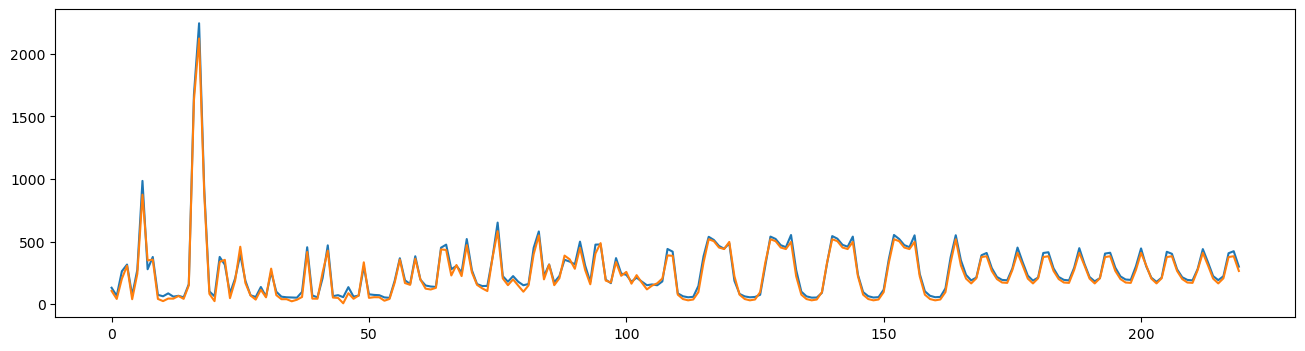

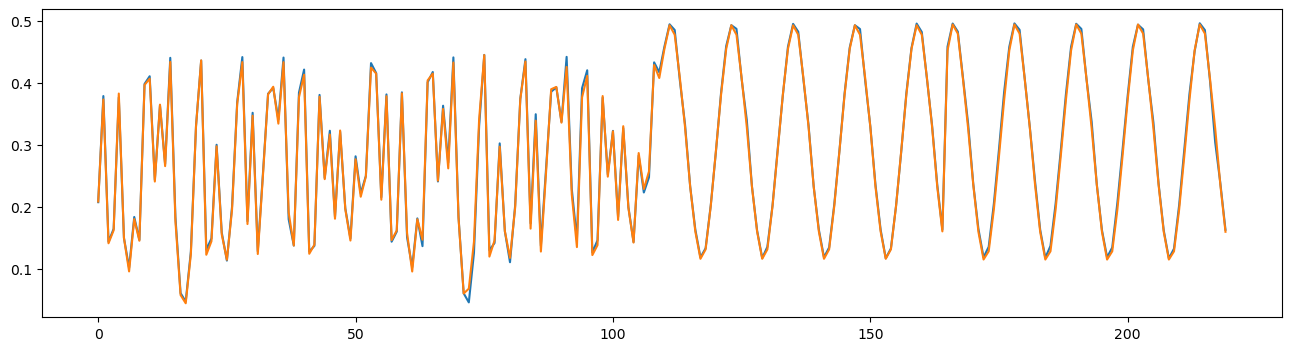

y_train_ESN2 shape: (800, 2)
x_train_ESN2 shape: (800, 1000)


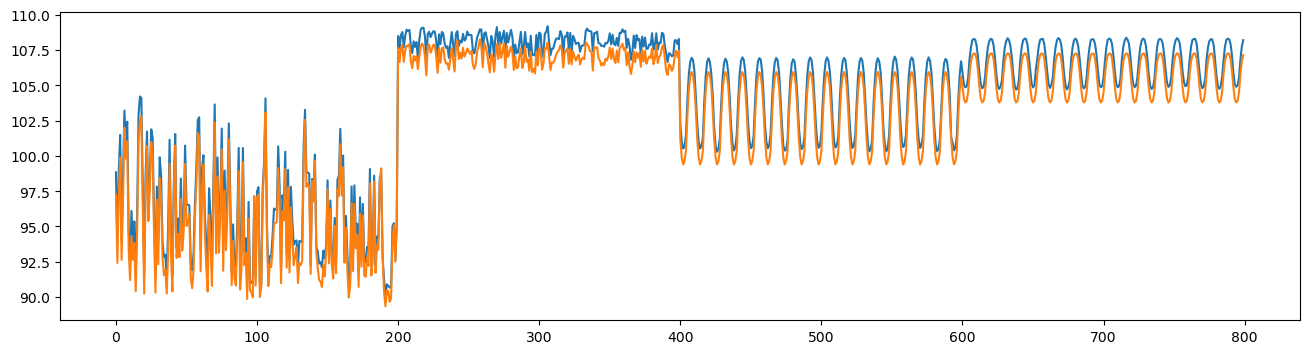

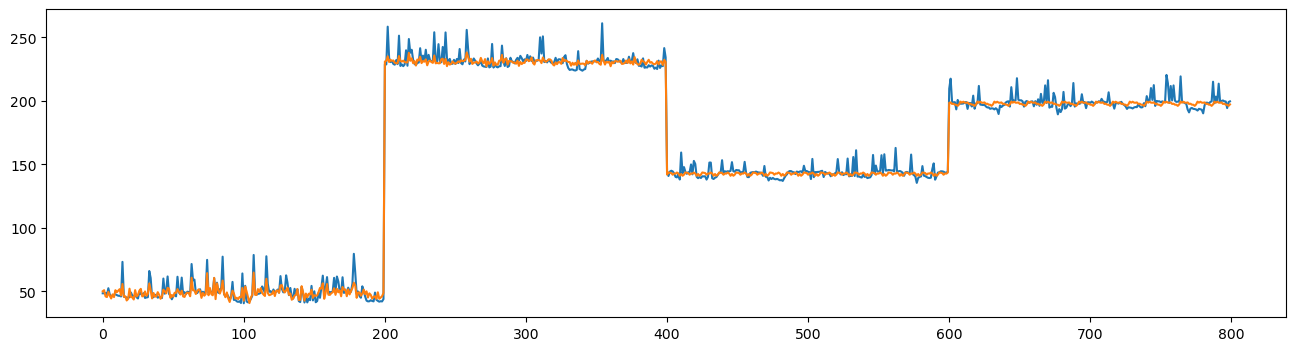

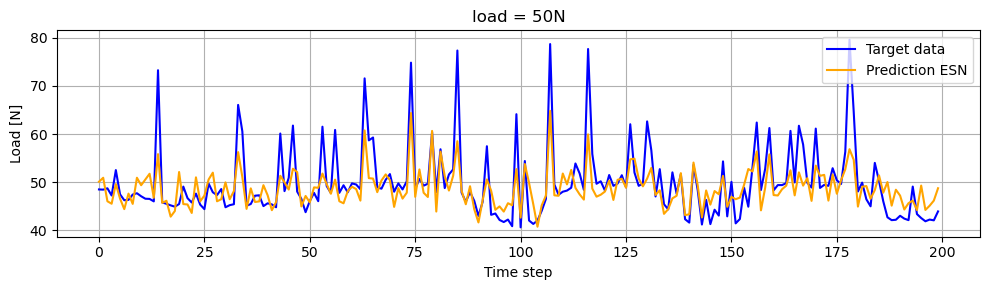

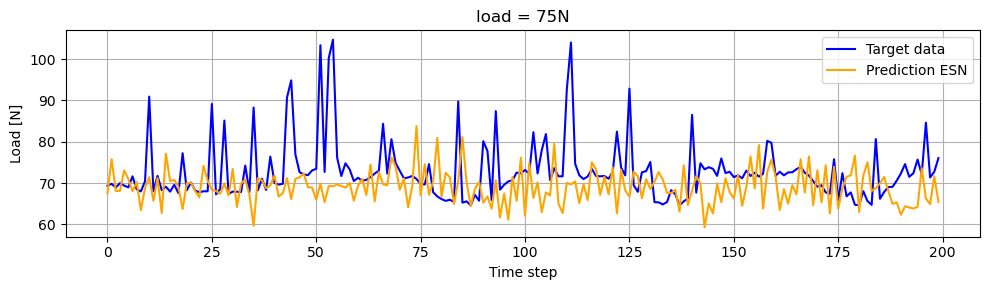

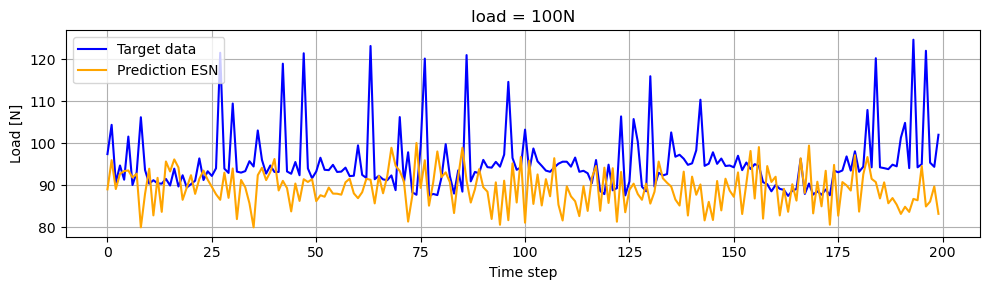

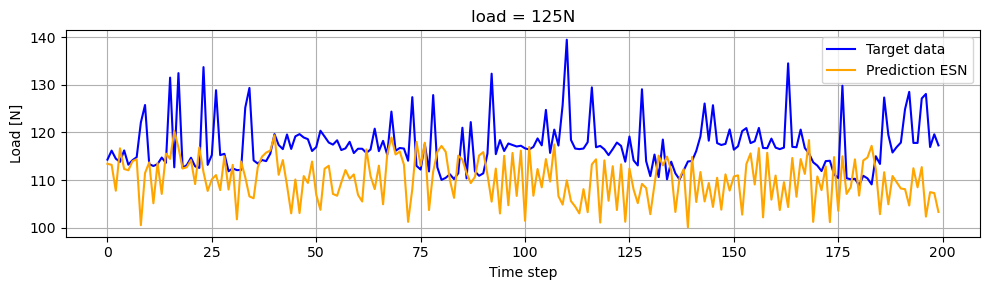

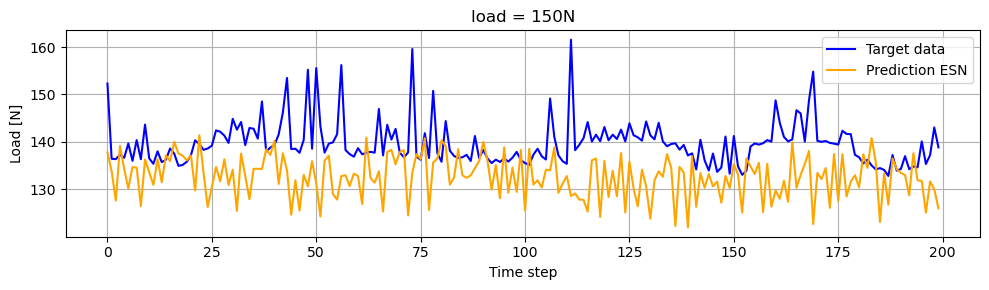

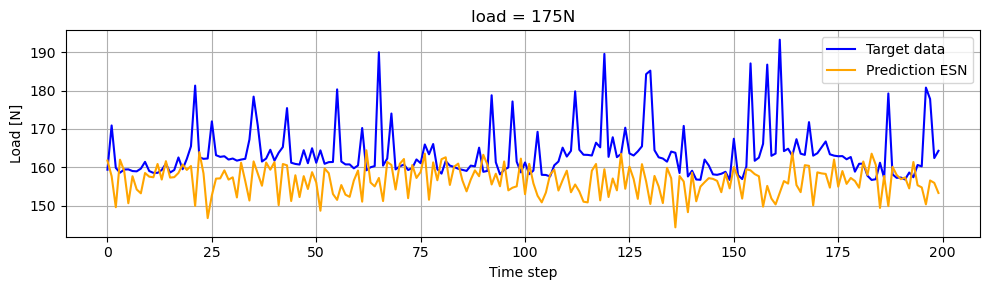

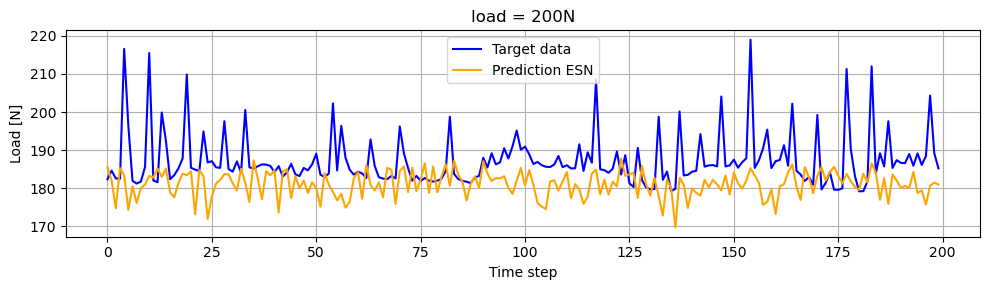

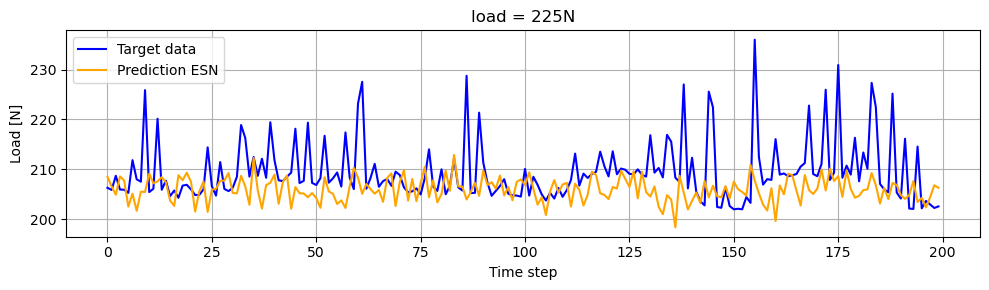

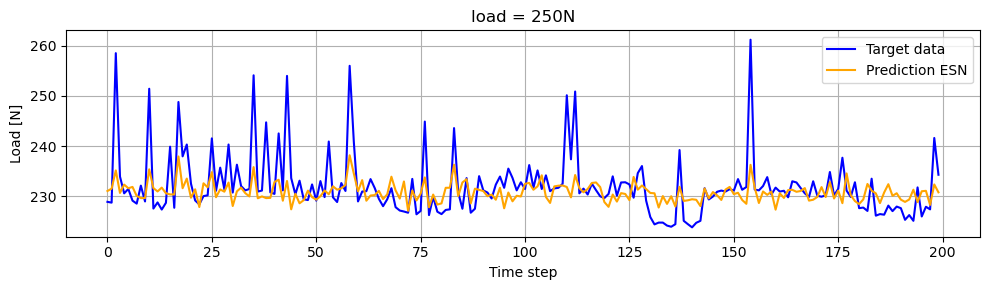

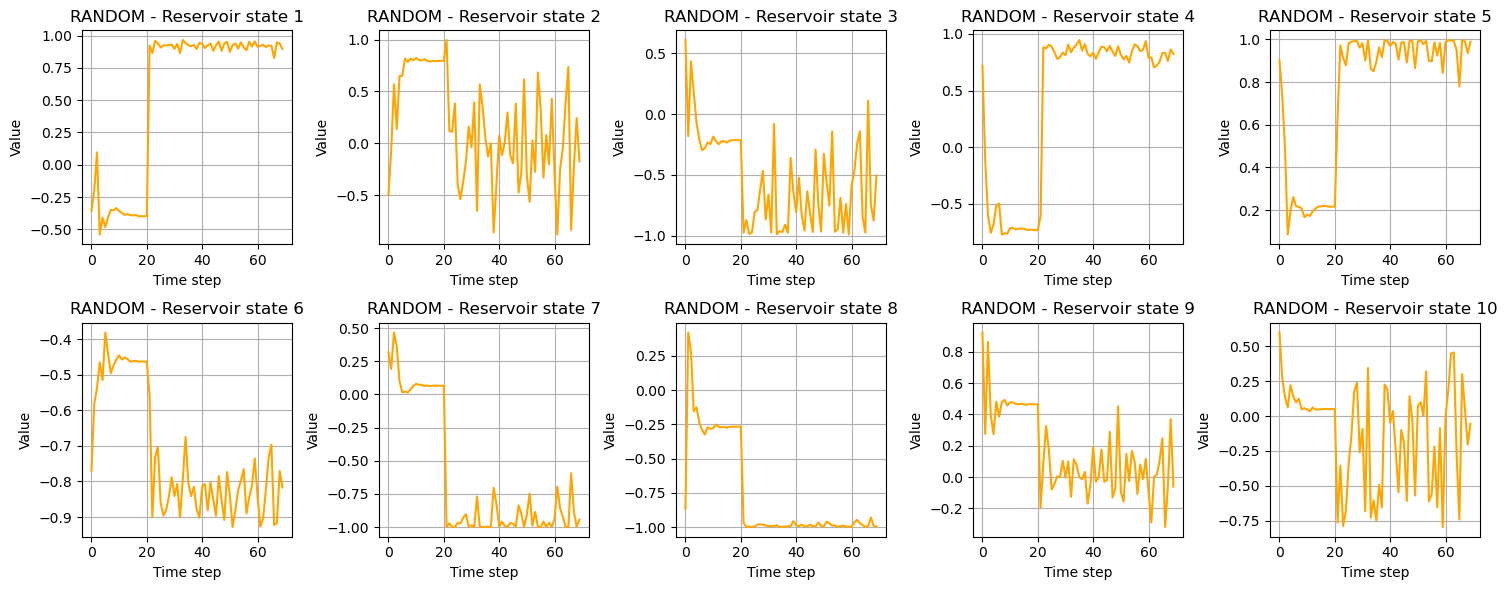

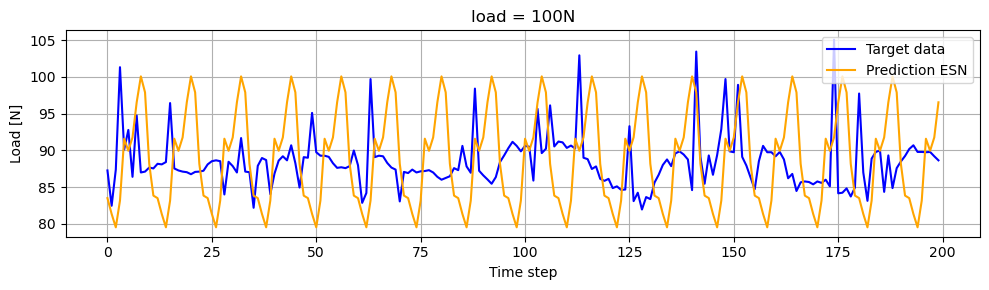

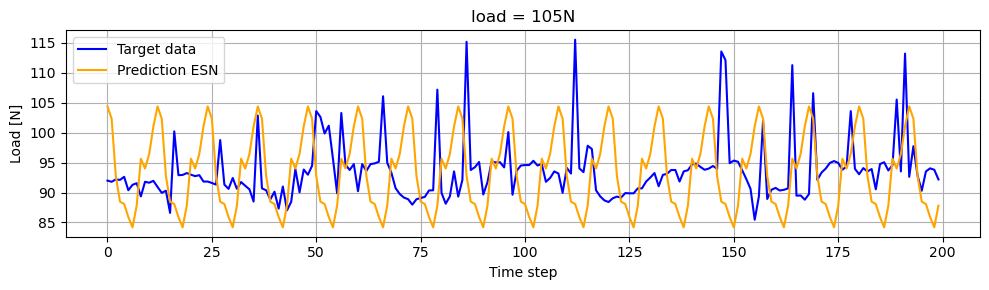

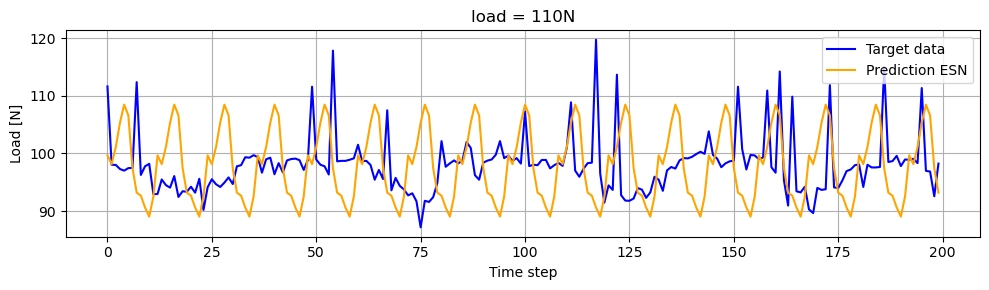

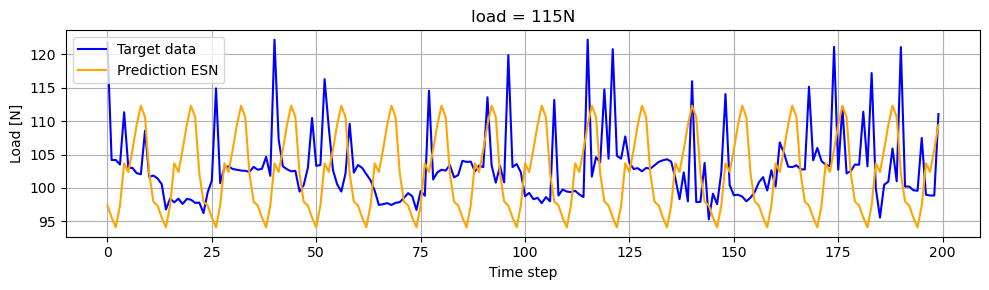

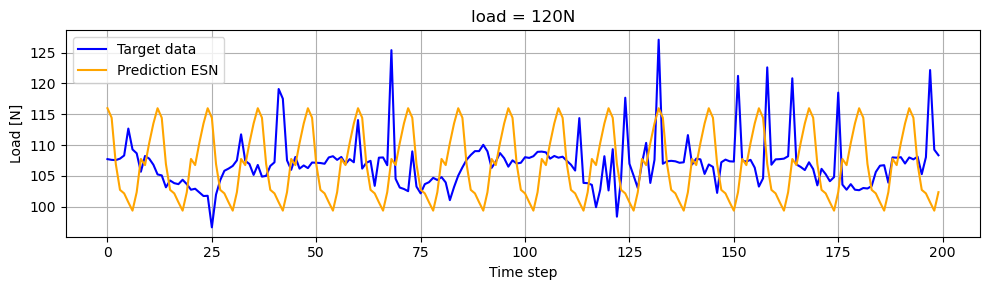

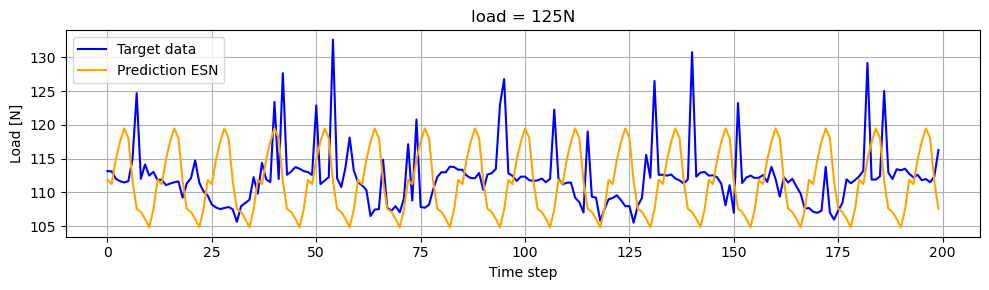

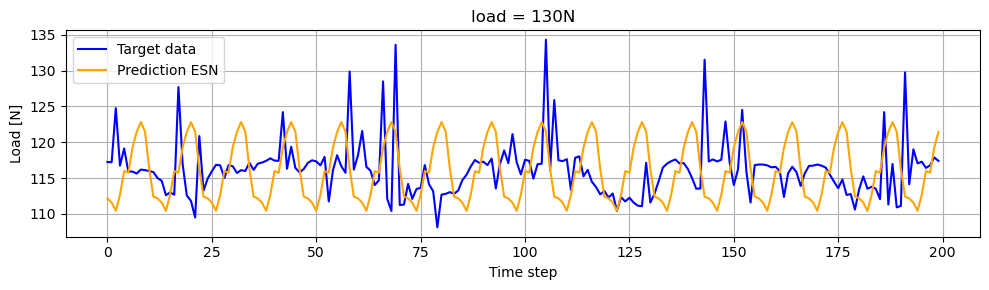

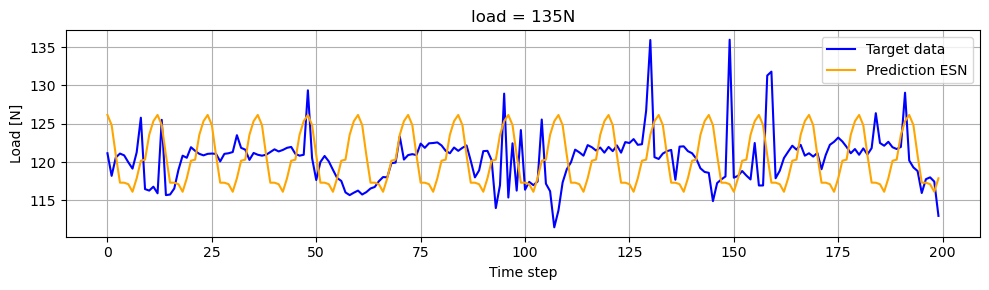

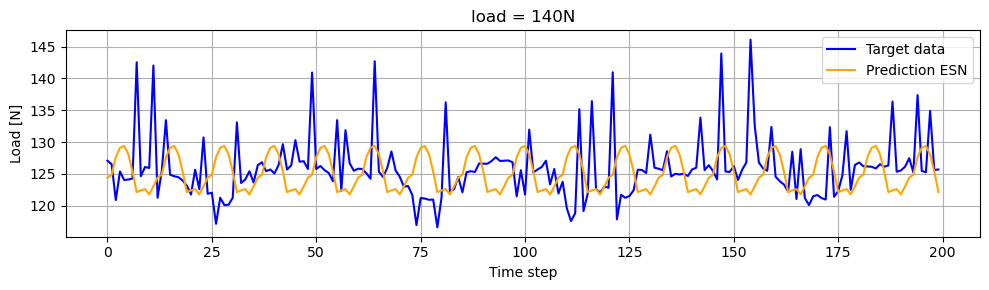

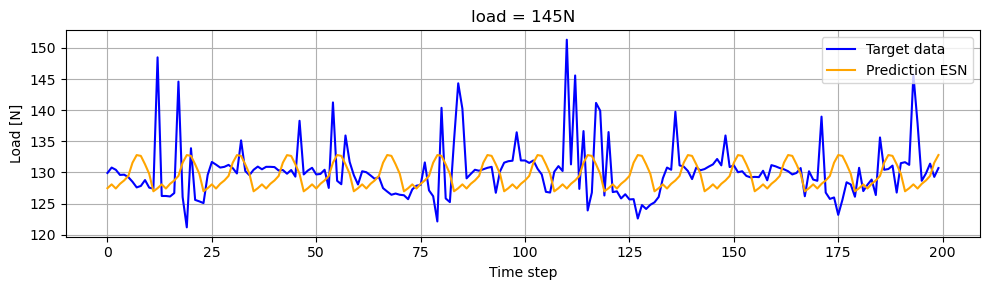

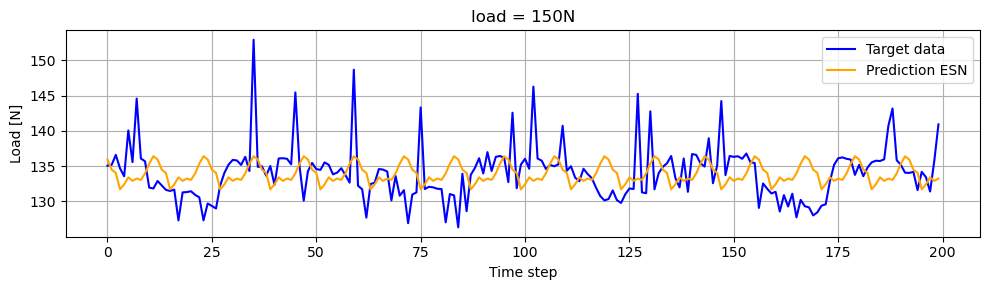

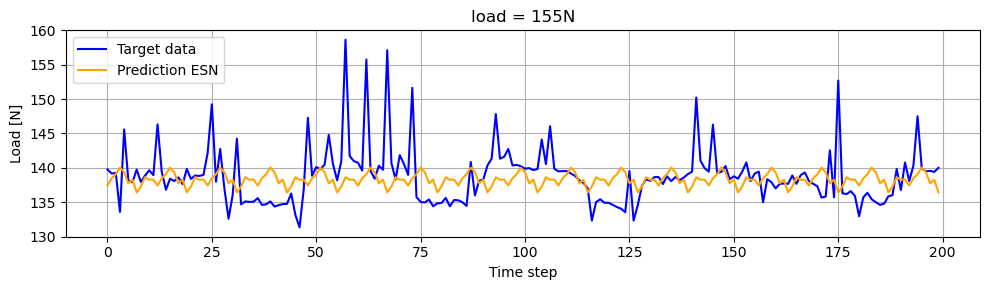

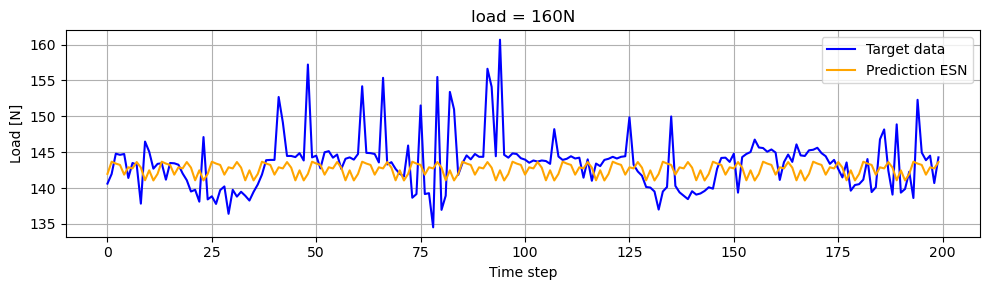

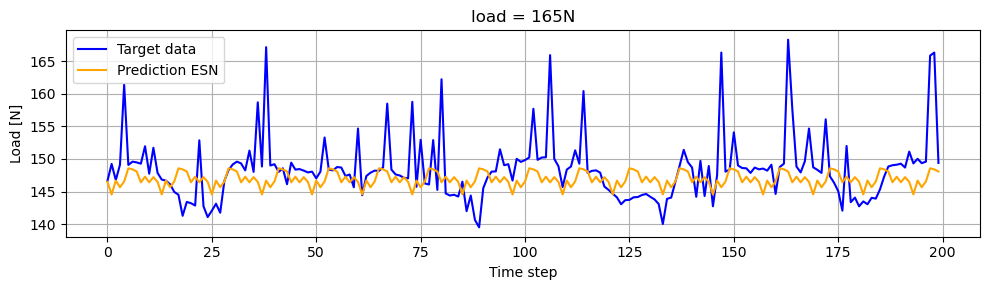

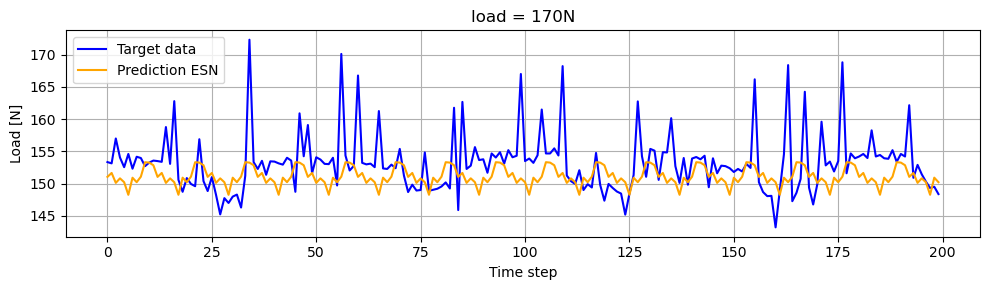

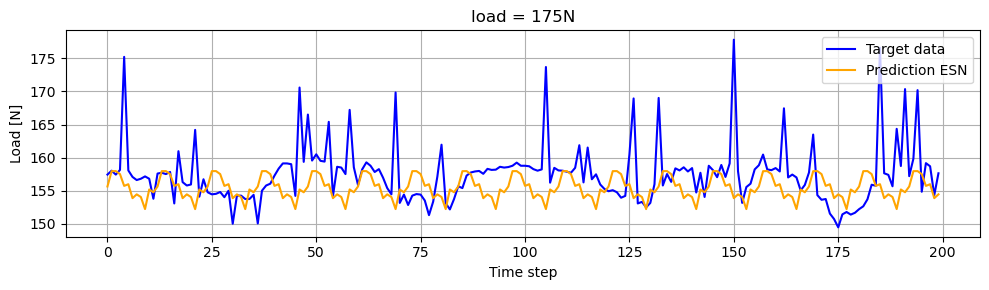

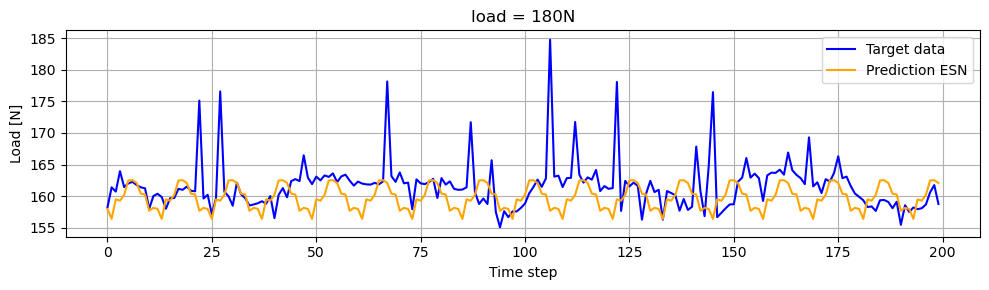

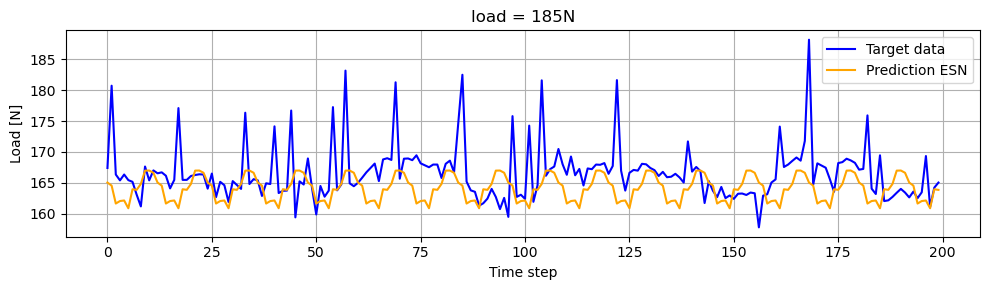

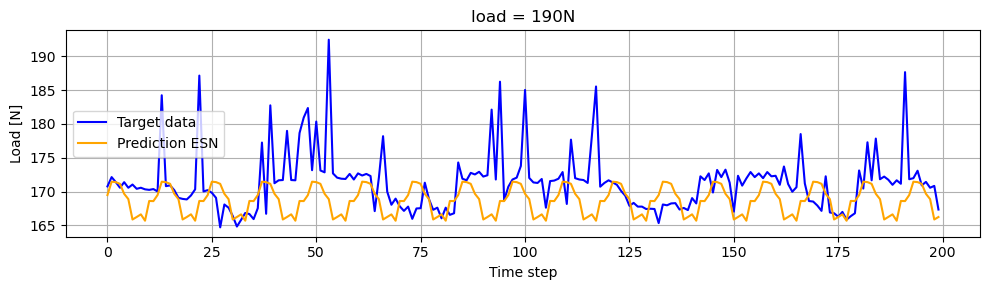

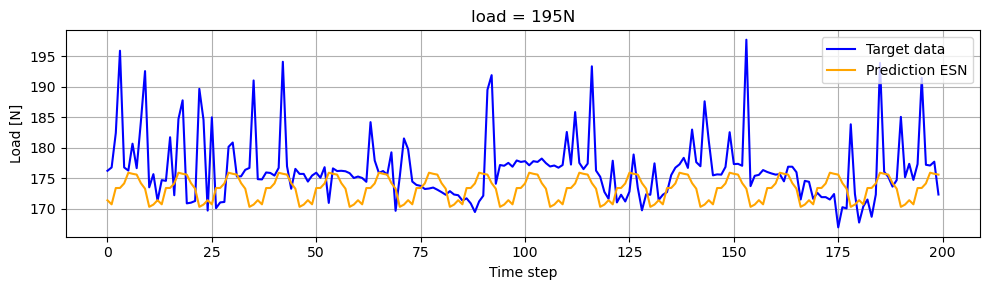

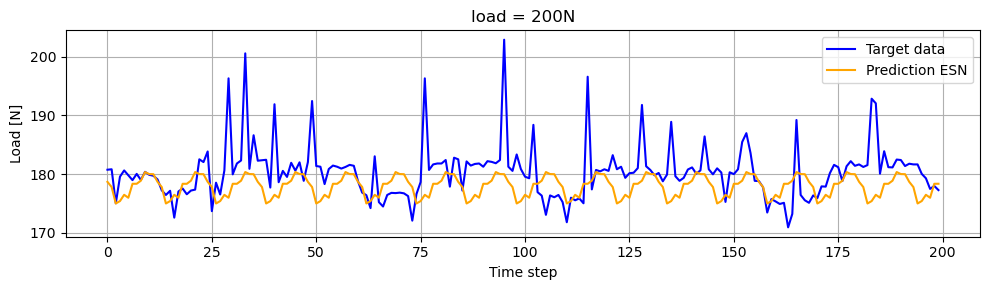

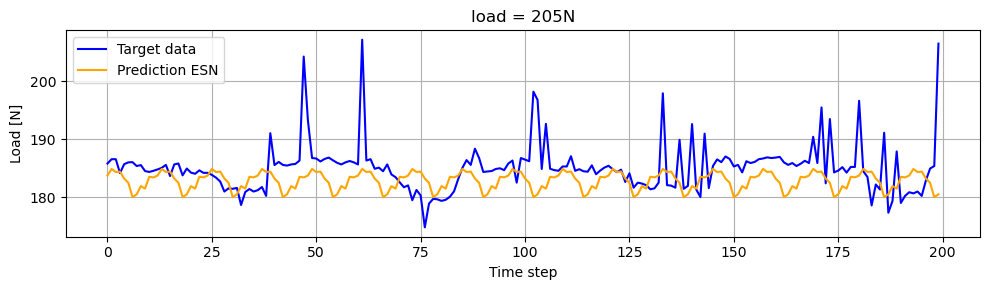

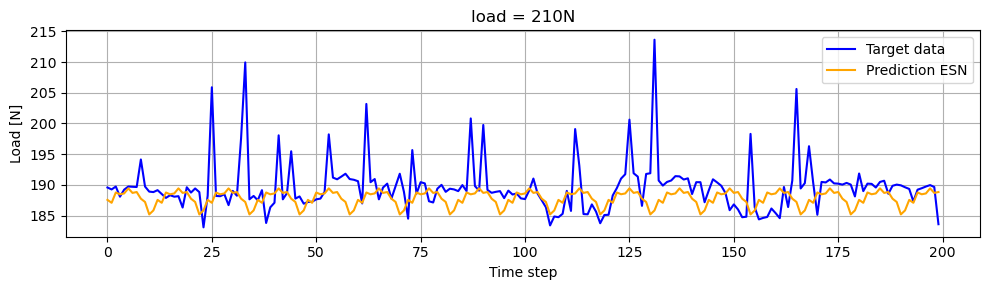

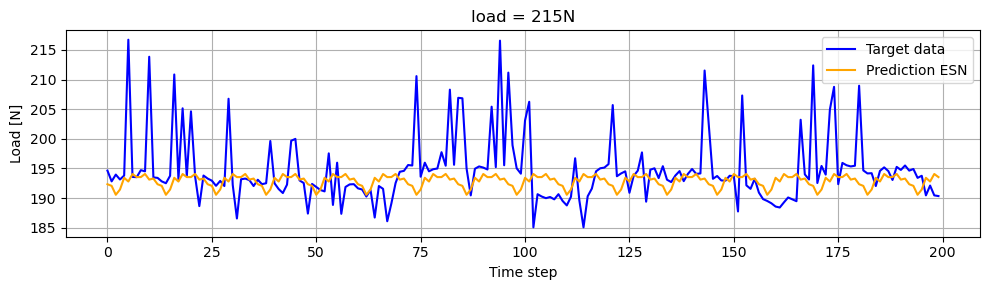

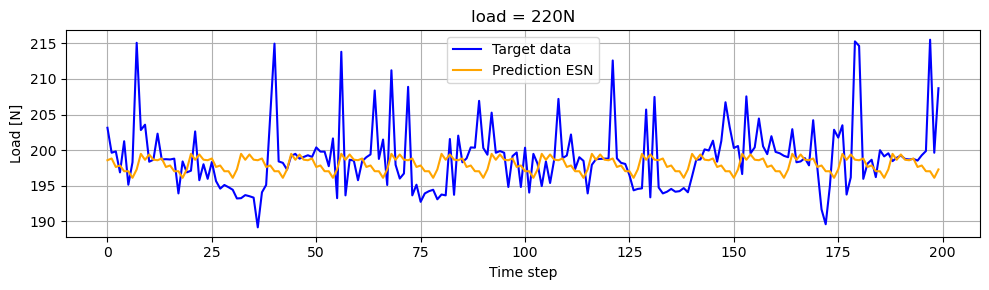

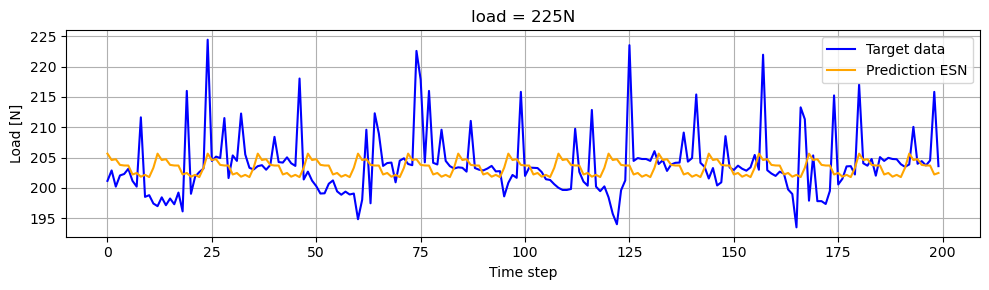

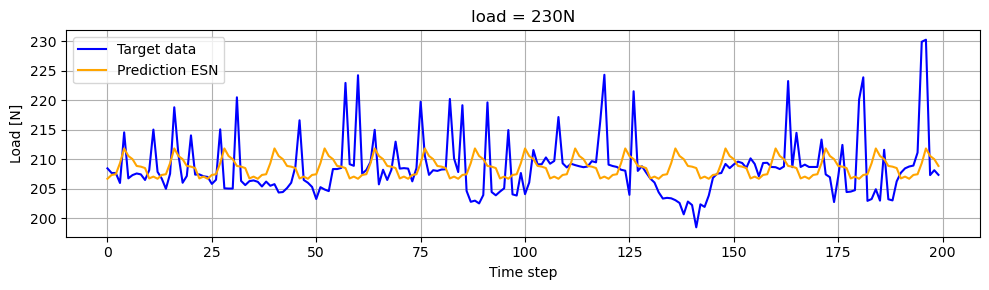

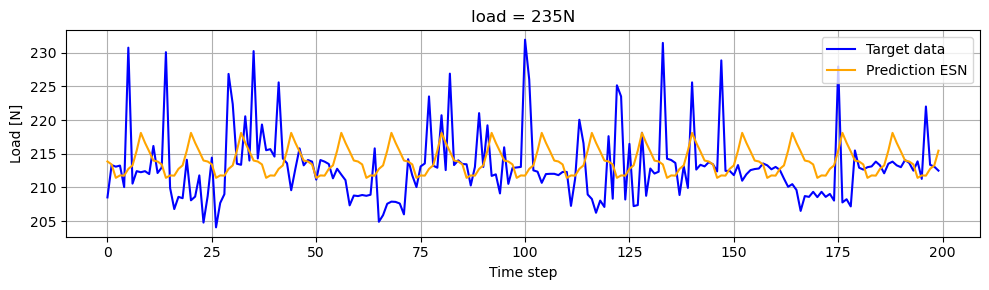

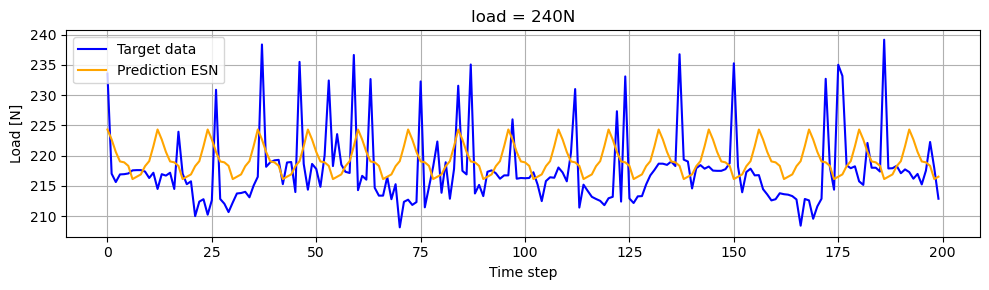

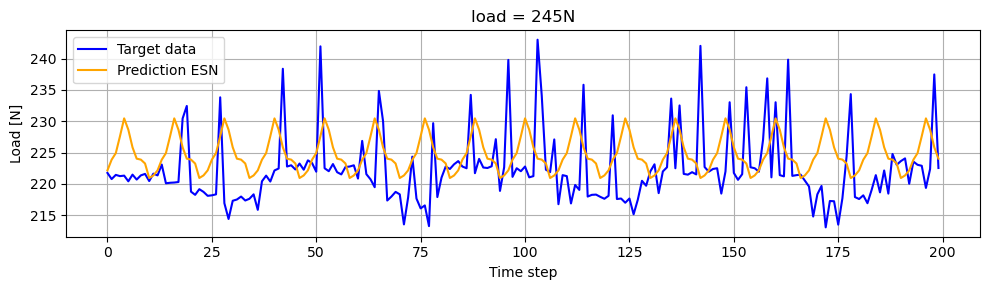

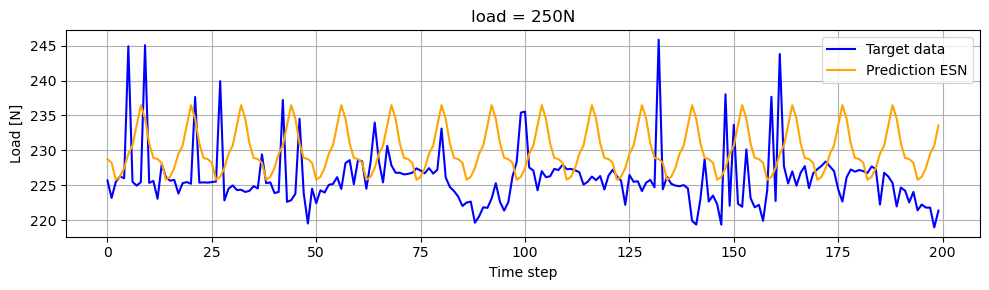

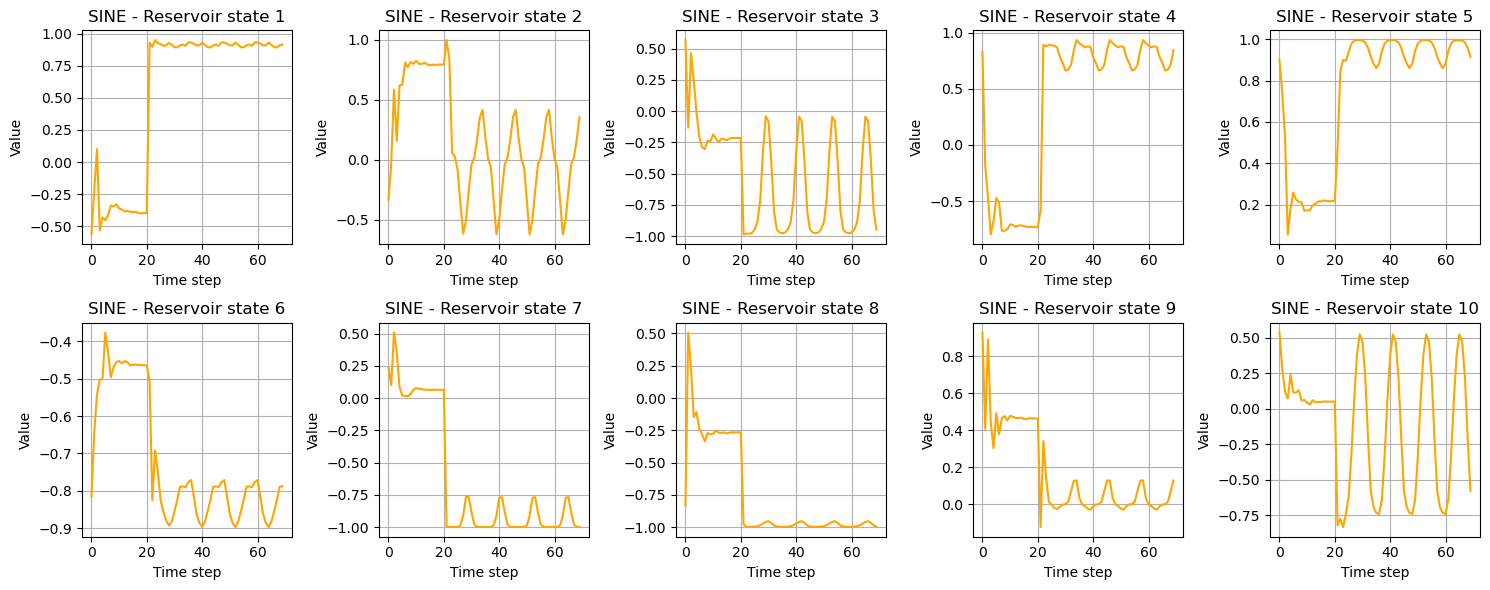

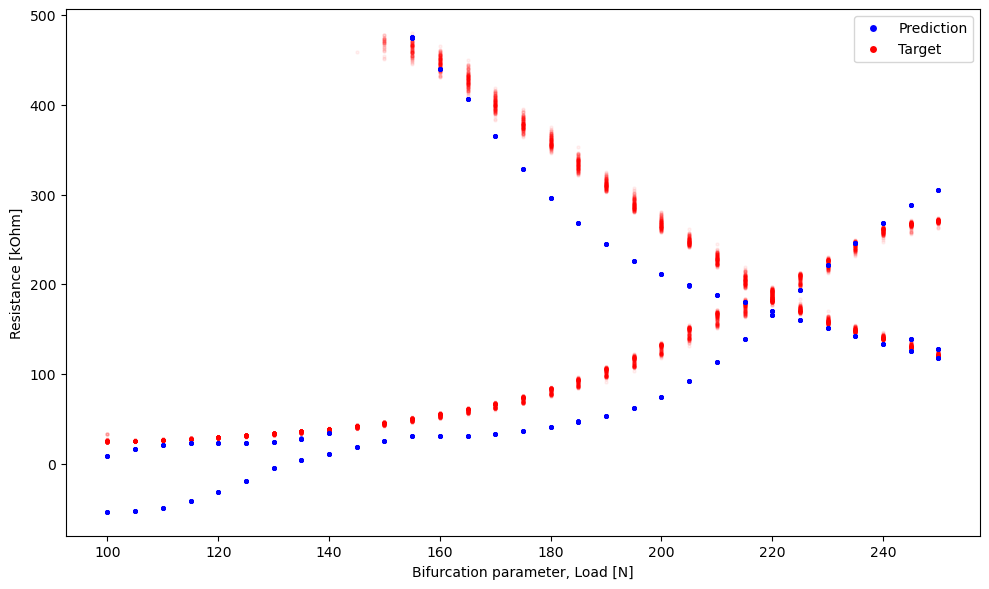

In [26]:
#Boucles sur les hyperparamètres
results = []
stockScores = []
for param_lambda in lambdasVals:
    print("Lambda =", param_lambda)
    for theDivideState in dividersState:
        for rho in rhoVals:
            for matrix_sparsity in sparsityVals:
                for theshrinkingFactor in shrinkingFactors:
                    print("TheshrinkingFactor =", theshrinkingFactor)
                    for inputScaling1 in inputScalings1:
                        for reservoirScaling1 in reservoirScalings1:
                            for biasScaling in biasScalings:
                                for wnetVal in wnetFactors:
                                    for leaky_val in leakyVals:
                                        print("Leakage =", leaky_val)
                                     #for firstTrainingVal in firstTrainingVals:
                                        #print("first load train : ", firstTrainingVal)
                                        for winVal in winFactors:
                                            for dim_esn in dimESNvals:
                                                #  print("dimESN2 : ", dim_esn)
                                                for theBiasesFactor in theBiasesFactors:
                                                    for t_train in nbTrain:
                                                        # print("t_train : ", t_train)
                                                        for t_washout in nbWashout:
                                                            for shiftTrain in shiftsTrain :

                                                                params = {
                                                                    'lambda': param_lambda,
                                                                    'rho': rho,
                                                                    'sparsity': matrix_sparsity,
                                                                    'inputScaling': inputScaling1,
                                                                    'reservoirScaling': reservoirScaling1,
                                                                    'biasScaling': biasScaling,
                                                                    'leaky': leaky_val,
                                                                    'dim_esn': dim_esn,
                                                                    't_train': t_train,
                                                                    't_washout': t_washout
                                                                }

                                                                print(params)

                                                                dictBifurcationValues = {}
                                                                dictBifurcationValues2 = {}


                                                                # ESN2 : transforme la prédiction normalisée de ESN1 en valeur brute.
                                                                # On choisit ici 2 entrées : [ESN1_prediction, load (brute)]
                                                                dim_in_ESN2 = 2
                                                                dim_out_ESN2 = 2

                                                                dim_in_ESN1 = 2
                                                                dim_out_ESN1 = 2

                                                                # Initialisation du générateur et conditions initiales
                                                                rnd = np.random.default_rng(1234)
                                                                reservoirScaling = 0
                                                                ###### Initialisation de l'ESN2 ######
                                                                x_init = rnd.uniform(low=-0, high=0, size=(dim_esn,))

                                                                w_in1 = Linear(dim_in_ESN1, 1000, bound=2.5,
                                                                                        LowboundBias=-2.5, HighboundBias=2.5, rnd=rnd)

                                                                w_in2 = Linear(dim_in_ESN2, dim_esn, bound=inputScaling1,
                                                                                        LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)

                                                                net1 = ESN(
                                                                    dim=1000,
                                                                    sr=0.95,
                                                                    a=1,
                                                                    f=np.tanh,
                                                                    p=1,
                                                                    init_state=x_init,
                                                                    rnd=rnd,
                                                                    normalize=True,
                                                                    wpFactor=0,
                                                                    wnetFactor=wnetVal,
                                                                    knet=1,
                                                                    kbias = 0.55,
                                                                    theBiasFactor = theBiasesFactor,
                                                                    shrinkingFactor = theshrinkingFactor,
                                                                    divideStates = theDivideState
                                                                )

                                                                net2 = ESN(
                                                                    dim=dim_esn,
                                                                    sr=rho,
                                                                    a=leaky_val,
                                                                    f=np.tanh,
                                                                    p=matrix_sparsity,
                                                                    init_state=x_init,
                                                                    rnd=rnd,
                                                                    normalize=True,
                                                                    wpFactor=0,
                                                                    wnetFactor=wnetVal,
                                                                    knet=reservoirScaling1,
                                                                    kbias = biasScaling,
                                                                    theBiasFactor = theBiasesFactor,
                                                                    shrinkingFactor = theshrinkingFactor,
                                                                    divideStates = theDivideState
                                                                )
                                                                w_out1 = RidgeReadout(1000, dim_out_ESN1, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=1, rnd=rnd)

                                                                w_out2 = RidgeReadout(dim_esn, dim_out_ESN2, bound=sigma_output,
                                                                                            LowboundBias=-1, HighboundBias=1,
                                                                                            lmbd=param_lambda, rnd=rnd)


                                                                loadTraining = [(50,'rand'), (250,'rand'),(160,'sine'), (220,'sine')]#(50,'rand'),(175,'rand'), (225,'rand'), (160,'sine'), (220,'sine')]


                                                                # Définition des bornes et dimensions
                                                                numeric_loads = [val for val, _ in loadTraining]
                                                                loadValMin = min(100,np.min(numeric_loads))#100
                                                                loadValMax =max(250,np.max(numeric_loads))#250

                                                                t_total = t_washout + t_train

                                                                ######################################################################
                                                                #TRAINING FIRST ESN
                                                                ######################################################################
                                                                x_train_ESN1 = []
                                                                y_train_ESN1 = []

                                                                numberOfMultiplexage =1#5

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                      inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                      inputReservoir = w_in1(inputWashout, beta=0, winFactor=winVal)
                                                                      net1.step(inputReservoir, p =0)

                                                                    for t in range(shiftTrain, shiftTrain+t_train):
                                                                      t_actual = t
                                                                      current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                            load_valNormalized]

                                                                      inputReservoir = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                      net1.step(inputReservoir, p=0)

                                                                      if t_actual>=heatTime: #Phase de "chauffe" des états du réservoir
                                                                        x_train_ESN1.append(np.copy(net1.x)) #reservoir states
                                                                        y_train_ESN1.append([electricalResistance[t_actual],  pressureMeas[t_actual]])

                                                                x_train_ESN1 = np.array(x_train_ESN1)
                                                                y_train_ESN1 = np.array(y_train_ESN1)

                                                                w_out1.train(x_train_ESN1, y_train_ESN1)

                                                                plotTrainingResult(wout = w_out1, x_train_ESN2 = x_train_ESN1, y_train_ESN2 = y_train_ESN1)

                                                                ##################################
                                                                # TRAINING OF THE SECOND READOUT #
                                                                ##################################

                                                                x_train_ESN2 = []
                                                                y_train_ESN2 = []

                                                                for load_val, type in loadTraining:
                                                                  for indexColumn in range(numberOfMultiplexage):

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value = load_val, type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)

                                                                    for t in range(t_washout):
                                                                        #inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                       # net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        #current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                            #  load_valNormalized]

                                                                       # in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                       # net1.step(in_1, p=0)

                                                                        #y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                       # y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                       # inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                       # inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)

                                                                        if t_actual>=heatTime: #Phase de "chauffe" des états du réservoir
                                                                            x_train_ESN2.append(np.copy(net2.x)) #reservoir states
                                                                            y_train_ESN2.append([length[t_actual],  load_meas[t_actual]])

                                                                x_train_ESN2 = np.array(x_train_ESN2)
                                                                y_train_ESN2 = np.array(y_train_ESN2)

                                                                w_out2.train(x_train_ESN2, y_train_ESN2)

                                                                plotTrainingResult(wout=w_out2, x_train_ESN2 = x_train_ESN2, y_train_ESN2 = y_train_ESN2)

                                                                #############################################################
                                                                # Phase de prédiction en chaîne pour les 2 readouts #
                                                                #############################################################
                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresRandom = []

                                                                for load_val in range(50, 251, 25):
                                                                  for indexColumn in range(numberOfMultiplexage):
                                                                    type = "rand"

                                                                    if(indexColumn>0 and type =="sine"):
                                                                        break

                                                                    electricalResistance,pressure,pressureMeas,length,load_meas  = getTheData(load_value=load_val,type=type, mux = indexColumn)
                                                                    electricalResistanceNormalized, pressureNormalized, pressureMeasNormalized, lengthNormalized, load_valNormalized = normalizeTheData(electricalResistance,pressure,pressureMeas,length,load_meas, loadTraining)


                                                                    # Predictions ESN
                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    oneReservoir2StateValue = []
                                                                    cpt = 0

                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                        net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                        #oneReservoir2StateValue.append(net1.x[80:90].copy())



                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                            oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                            #oneReservoir2StateValue.append(net1.x[80:90].copy())


                                                                        current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                        net1.step(in_1, p=0)

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)

                                                                        y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                        y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                        y_out3 = w_out2(np.copy(net2.x))[0][0]
                                                                        y_out4 = w_out2(np.copy(net2.x))[0][1]

                                                                        #predictedLength = y_out3
                                                                        #predictedLoad = y_out4

                                                                        #inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        #inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out1
                                                                          y_pred_pressure[t_actual-heatTime] = y_out2
                                                                          y_pred_length[t_actual-heatTime] = y_out3
                                                                          y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    #SCORE :
                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    scoresRandom.append(batch_score)

                                                                    title_str = (f"load = {load_val}, λ={param_lambda}, ρ={rho}, p={matrix_sparsity}\n"
                                                                                 f"a={leaky_val}, β={betaValue}\n"
                                                                                 f"wnet={wnetVal}, win={winVal}\n"
                                                                                 f"dim_esn={dim_esn}, t_train={t_train}, t_washout={t_washout}")

                                                                    if (viewElec and ((load_val == 50) or (load_val == 110) or (load_val == 200)) and indexColumn == 0):

                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLength):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLoad):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()


                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                finalScoreRandom = np.mean(scoresRandom)
                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'RANDOM - Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)

                                                                #SECOND TEST DATAS FOR SINE INPUT
                                                                dictBifurcationValues = {}

                                                                bifurcation_data_prediction = []
                                                                all_rmse_per_load = []

                                                                scoresSine = []

                                                                for load_val in range(100, 251, 5):
                                                                  for indexColumn in range(numberOfMultiplexage):
                                                                    type = 'sine'
                                                                    if(indexColumn>0):
                                                                        break


                                                                    oneReservoir2StateValue = []

                                                                    start_index = int(((load_val - 100) / deltaLoadSine) * nbMeasuresSine)
                                                                    electricalResistance = PAM1data[start_index:(start_index + nbMeasures), multiplexageResistance[indexColumn]] / 1e3
                                                                    pressure = PAM1data[start_index:(start_index + nbMeasures), multiplexagePressure[indexColumn]]
                                                                    pressureMeas = PAM1data[start_index:(start_index + nbMeasures), multiplexageMeasuredPressure[indexColumn]]
                                                                    length = PAM1data[start_index:(start_index + nbMeasures), multiplexageLength[indexColumn]]
                                                                    load_meas = PAM1data[start_index:(start_index + nbMeasures), multiplexageLoadMeas[indexColumn]]


                                                                    # Normalization for ESN
                                                                    electricalResistanceNormalized = (electricalResistance-np.min(electricalResistance))/(np.max(electricalResistance)-np.min(electricalResistance))
                                                                    pressureNormalized = (pressure-np.min(pressure))/(np.max(pressure)-np.min(pressure))
                                                                    pressureMeasNormalized = (pressureMeas-np.min(pressureMeas))/(np.max(pressureMeas)-np.min(pressureMeas))
                                                                    lengthNormalized = (length-np.min(length))/(np.max(length)-np.min(length))

                                                                    load_valNormalized = (load_val - loadValMin) / (loadValMax - loadValMin)


                                                                    # Predictions ESN

                                                                    y_pred_elec = np.zeros(t_predict)
                                                                    y_pred_length = np.zeros(t_predict)
                                                                    y_pred_pressure = np.zeros(t_predict)
                                                                    y_pred_load = np.zeros(t_predict)

                                                                    cpt = 0


                                                                    for t in range(t_washout):
                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN1)
                                                                        net1.step(w_in1(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        inputWashout = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN2)
                                                                        net2.step(w_in2(inputWashout, beta=0, winFactor=winVal), p =0)

                                                                        oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                        #oneReservoir2StateValue.append(net2.x[80:90].copy())





                                                                    for t in range(heatTime+t_predict):
                                                                        t_actual = t

                                                                        if t_actual <50: #get extra reservoir states after washout
                                                                          oneReservoir2StateValue.append(np.concatenate((net1.x[80:85], net2.x[80:85])))
                                                                          #oneReservoir2StateValue.append(net2.x[80:90].copy())



                                                                        current_input_ESN1 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_1 = w_in1(current_input_ESN1, beta=betaValue, winFactor=winVal)
                                                                        net1.step(in_1, p=0)

                                                                        current_input_ESN2 = [pressureNormalized[t_actual],
                                                                                              load_valNormalized]

                                                                        in_2 = w_in2(current_input_ESN2, beta=betaValue, winFactor=winVal)
                                                                        net2.step(in_2, p=0)

                                                                        y_out1 = w_out1(np.copy(net1.x))[0][0]
                                                                        y_out2 = w_out1(np.copy(net1.x))[0][1]

                                                                        #predictedElec = y_out1
                                                                        #predictedPressure = y_out2

                                                                        y_out3 = w_out2(np.copy(net2.x))[0][0]
                                                                        y_out4 = w_out2(np.copy(net2.x))[0][1]

                                                                        #predictedLength = y_out3
                                                                        #predictedLoad = y_out4

                                                                        #inputElecESN = (predictedElec-Rmin)/(Rmax-Rmin)
                                                                        #inputPressureESN = (predictedPressure-Pmin)/(Pmax-Pmin)

                                                                        if t_actual >=heatTime: #"Heat" phase for the reservoir states
                                                                          y_pred_elec[t_actual-heatTime] = y_out1
                                                                          y_pred_pressure[t_actual-heatTime] = y_out2
                                                                          y_pred_length[t_actual-heatTime] = y_out3
                                                                          y_pred_load[t_actual-heatTime] = y_out4

                                                                    y_target_elec = electricalResistance[heatTime:heatTime+t_predict]
                                                                    y_target_length = length[heatTime:heatTime+t_predict]
                                                                    y_target_pressure = pressureMeas[heatTime:heatTime+t_predict]
                                                                    y_target_load = load_meas[heatTime:heatTime+t_predict]

                                                                    scoreElec = eval_esn_score(y_pred = y_pred_elec,y_target = y_target_elec)
                                                                    scoreLength = eval_esn_score(y_pred = y_pred_length,y_target = y_target_length)
                                                                    scorePressure = eval_esn_score(y_pred = y_pred_pressure,y_target = y_target_pressure)
                                                                    scoreLoad = eval_esn_score(y_pred = y_pred_load,y_target = y_target_load)

                                                                    batch_score = np.quantile([scoreElec, scoreLength, scorePressure, scoreLoad], 0.75)
                                                                    scoresSine.append(batch_score)

                                                                    dictBifurcationValues = createMyBifurcationDiagram(y_pred_elec, dictBifurcationValues, load_val)

                                                                    title_str = (f"load = {load_val}, λ={param_lambda}, ρ={rho}, p={matrix_sparsity}\n"
                                                                                 f"a={leaky_val}, β={betaValue}\n"
                                                                                 f"wnet={wnetVal}, win={winVal}\n"
                                                                                 f"dim_esn={dim_esn}, t_train={t_train}, t_washout={t_washout}")


                                                                     # --- Bloc corrigé pour tracer une seule figure fixe par load_val ---
                                                                    if (viewElec and ((load_val == 50) or (load_val == 110) or (load_val == 200)) and indexColumn == 0):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_elec,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_elec,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    if(viewLength):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_length,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_length,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Length [mm]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewPressure):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_pressure,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_pressure,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Pressure [MPa]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()

                                                                    if(viewLoad):# and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                        fig, ax = plt.subplots(figsize=(10, 3))

                                                                        # tracé de la série Target
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_target_load,
                                                                            label='Target data',
                                                                            color='blue'
                                                                        )

                                                                        # tracé de la prédiction ESN
                                                                        ax.plot(
                                                                            range(t_predict),
                                                                            y_pred_load,
                                                                            label='Prediction ESN',
                                                                            color='orange'
                                                                        )

                                                                        # étiquettes et grille
                                                                        ax.set_xlabel('Time step')
                                                                        ax.set_ylabel('Load [N]')
                                                                        ax.set_title(f"load = {load_val}N")
                                                                        ax.legend()
                                                                        ax.grid(True)

                                                                        # disposition compacte
                                                                        plt.tight_layout()
                                                                        plt.show()
                                                                    # si la condition n'est pas remplie, on ne trace rien et on continue la boucle



                                                                finalScoreSine = np.mean(scoresSine)

                                                                # Stockage des résultats
                                                                results.append((params, finalScoreRandom, finalScoreSine))
                                                                stockScores.append((finalScoreRandom, finalScoreSine))

                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'SINE - Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)


                                                                fig, ax = plt.subplots(figsize=(10, 6))


                                                                plotBifurcation(dictBifurcationValues, ax = ax)

                                                                multiplexage_columns = multiplexageResistance

                                                                colors = ['red']* len(multiplexage_columns)
                                                                labels = ['Target']#Multiplexage {col}' for col in multiplexage_columns]


                                                                # On suppose que 'data' est déjà défini (ex. un array numpy contenant vos données)
                                                                #plot_target_bifurcation(ax, data, multiplexage_columns, load_values, nbMeasures, deltaLoad, num_points, colors, labels)

                                                                plot_target_bifurcation(
                                                                    ax,
                                                                    PAM1data,
                                                                    multiplexage_columns,
                                                                    load_values,
                                                                    nbMeasures,
                                                                    deltaLoad,
                                                                    num_points
                                                                )

                                                                from matplotlib.lines import Line2D

                                                                legend_elements = [
                                                                    Line2D([0], [0], marker='o', color='w', label='Prediction',
                                                                           markerfacecolor='blue', markersize=6),
                                                                    Line2D([0], [0], marker='o', color='w', label='Target',
                                                                           markerfacecolor='red', markersize=6)
                                                                ]
                                                                ax.legend(handles=legend_elements)

                                                                # Configuration finale du plot
                                                                ax.set_xlabel('Bifurcation parameter, Load [N]')
                                                                ax.set_ylabel('Resistance [kOhm]')

                                                                plt.tight_layout()
                                                                plt.show()






2 reservoirs decorrelles

In [ ]:
#Boucles sur les hyperparamètres
results = []
stockScores = []
for param_lambda in lambdasVals:
    print("Lambda =", param_lambda)
    for theDivideState in dividersState:
        for rho in rhoVals:
            for matrix_sparsity in sparsityVals:
                for theshrinkingFactor in shrinkingFactors:
                    print("TheshrinkingFactor =", theshrinkingFactor)
                    for inputScaling1 in inputScalings1:
                        for reservoirScaling1 in reservoirScalings1:
                            for biasScaling in biasScalings:
                                for wnetVal in wnetFactors:
                                    for leaky_val in leakyVals:
                                        print("Leakage =", leaky_val)
                                     #for firstTrainingVal in firstTrainingVals:
                                        #print("first load train : ", firstTrainingVal)
                                        for winVal in winFactors:
                                            for dim_esn in dimESNvals:
                                                #  print("dimESN2 : ", dim_esn)
                                                for theBiasesFactor in theBiasesFactors:
                                                    for t_train in nbTrain:
                                                        # print("t_train : ", t_train)
                                                        for t_washout in nbWashout:
                                                            for shiftTrain in shiftsTrain :

                                                                params = {
                                                                    'lambda': param_lambda,
                                                                    'rho': rho,
                                                                    'sparsity': matrix_sparsity,
                                                                    'inputScaling': inputScaling1,
                                                                    'reservoirScaling': reservoirScaling1,
                                                                    'biasScaling': biasScaling,
                                                                    'leaky': leaky_val,
                                                                    'dim_esn': dim_esn,
                                                                    't_train': t_train,
                                                                    't_washout': t_washout
                                                                }

                                                                dictBifurcationValues = {}
                                                                dictBifurcationValues2 = {}


                                                                # ESN2 : transforme la prédiction normalisée de ESN1 en valeur brute.
                                                                # On choisit ici 2 entrées : [ESN1_prediction, load (brute)]
                                                                dim_in_ESN2 = 4
                                                                dim_out_ESN2 = 2

                                                                dim_in_ESN1 = 2
                                                                dim_out_ESN1 = 2

                                                                # Initialisation du générateur et conditions initiales
                                                                rnd = np.random.default_rng(1234)
                                                                reservoirScaling = 0
                                                                ###### Initialisation de l'ESN2 ######
                                                                x_init = rnd.uniform(low=-0, high=0, size=(dim_esn,))


                                                                loadTraining = [(75,'rand'), (100,'rand'), (250,'rand'),(155,'sine'), (220,'sine')]#(50,'rand'),(175,'rand'), (225,'rand'), (160,'sine'), (220,'sine')]


                                                                # Définition des bornes et dimensions
                                                                numeric_loads = [val for val, _ in loadTraining]
                                                                loadValMin = min(100,np.min(numeric_loads))#100
                                                                loadValMax =max(250,np.max(numeric_loads))#250

                                                                t_total = t_washout + t_train


                                                                # Réservoir 1 (ESN1)
                                                                w_in1 = Linear(dim_in_ESN1, dim_esn, bound=inputScaling1,
                                                                                LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)
                                                                net1 = ESN(dim=dim_esn, sr=rho, a=leaky_val, f=np.tanh, p=matrix_sparsity,
                                                                           init_state=rnd.uniform(-0,0,size=(dim_esn,)), rnd=rnd,
                                                                           normalize=True, wpFactor=0, wnetFactor=wnetVal,
                                                                           knet=reservoirScaling1, kbias=biasScaling,
                                                                           theBiasFactor=theBiasesFactor,
                                                                           shrinkingFactor=theshrinkingFactor,
                                                                           divideStates=theDivideState)
                                                                w_out1 = RidgeReadout(dim_esn, dim_out_ESN1, bound=sigma_output,
                                                                                      LowboundBias=-1, HighboundBias=1,
                                                                                      lmbd=second_param_lambda, rnd=rnd)

                                                                # Réservoir 2 (ESN2)
                                                                w_in2 = Linear(dim_in_ESN2, dim_esn, bound=inputScaling1,
                                                                                LowboundBias=-inputScaling1, HighboundBias=inputScaling1, rnd=rnd)
                                                                net2 = ESN(dim=dim_esn, sr=rho, a=leaky_val, f=np.tanh, p=matrix_sparsity,
                                                                           init_state=rnd.uniform(-0,0,size=(dim_esn,)), rnd=rnd,
                                                                           normalize=True, wpFactor=0, wnetFactor=wnetVal,
                                                                           knet=reservoirScaling1, kbias=biasScaling,
                                                                           theBiasFactor=theBiasesFactor,
                                                                           shrinkingFactor=theshrinkingFactor,
                                                                           divideStates=theDivideState)
                                                                w_out2 = RidgeReadout(dim_esn, dim_out_ESN2, bound=sigma_output,
                                                                                      LowboundBias=-1, HighboundBias=1,
                                                                                      lmbd=param_lambda, rnd=rnd)

                                                                # --- Fonction utilitaire washout + transient ---
                                                                def initialize_reservoir(dim_in_ESN, reservoir, w_in, washout_steps, transient_steps, input_seq=None):
                                                                    # washout aléatoire
                                                                    for _ in range(washout_steps):
                                                                        u0 = np.random.uniform(-washoutScaling, washoutScaling, size=dim_in_ESN)
                                                                        reservoir.step(w_in(u0, beta=0, winFactor=winVal), p=0)
                                                                    # transient avec entrée séquentielle si fournie
                                                                    if input_seq is not None:
                                                                        for u in input_seq[:transient_steps]:
                                                                            reservoir.step(w_in(u, beta=betaValue, winFactor=winVal), p=0)
                                                                    else:
                                                                        for _ in range(transient_steps):
                                                                            u0 = np.zeros(dim_in_ESN1)
                                                                            reservoir.step(w_in(u0, beta=0, winFactor=winVal), p=0)

                                                                # --- TRAINING ESN1 ---

                                                                numberOfMultiplexage = 1

                                                                X1, Y1 = [], []
                                                                for load_val, sig_type in loadTraining:
                                                                    for mux in range(numberOfMultiplexage):
                                                                        if mux>0 and sig_type=='sine': break
                                                                        # récupérer et normaliser
                                                                        R, P, Pm, L, Ld = getTheData(load_value = load_val, type = sig_type, mux = mux)
                                                                        Rn, Pn, Pmn, Ln, Ldn = normalizeTheData(R, P, Pm, L, Ld, loadTraining)
                                                                        # reset + washout + transient
                                                                        initialize_reservoir(dim_in_ESN1,net1, w_in1, t_washout, heatTime)
                                                                        # collecte pour training
                                                                        for t in range(t_train):
                                                                            idx = heatTime + t
                                                                            u = np.array([Pn[idx], Ldn])
                                                                            net1.step(w_in1(u, beta=betaValue, winFactor=winVal), p=0)
                                                                            X1.append(net1.x.copy())
                                                                            Y1.append([R[idx], Pm[idx]])
                                                                # entraîner le premier readout
                                                                X1, Y1 = np.array(X1), np.array(Y1)
                                                                w_out1.train(X1, Y1)
                                                                plotTrainingResult(X1,Y1)

                                                                # --- TRAINING ESN2 ---
                                                                # stocker bornes min/max de sortie 1
                                                                min_out1, max_out1 = Y1.min(axis=0), Y1.max(axis=0)

                                                                X2, Y2 = [], []
                                                                for load_val, sig_type in loadTraining:
                                                                    for mux in range(numberOfMultiplexage):
                                                                        if mux>0 and sig_type=='sine':
                                                                            break
                                                                        # récupérer et normaliser inputs pour ESN1
                                                                        R, P, Pm, L, Ld = getTheData(load_val, sig_type, mux)
                                                                        Rn, Pn, Pmn, Ln, Ldn = normalizeTheData(R, P, Pm, L, Ld, loadTraining)
                                                                        # prédire séquence ESN1
                                                                        initialize_reservoir(dim_in_ESN1,
                                                                            net1, w_in1,
                                                                            washout_steps = t_washout,
                                                                            transient_steps = heatTime,
                                                                            input_seq = [np.array([Pn[t], Ldn]) for t in range(heatTime + t_train)]
                                                                        )
                                                                        out1 = np.zeros((t_train, dim_out_ESN1))
                                                                        for t in range(t_train):
                                                                            idx = heatTime + t
                                                                            out1[t] = w_out1(np.copy(net1.x))[0]
                                                                        # 3) re-normaliser via l'inverse du min-max appris en training ESN1
                                                                        out1_norm = (out1 - min_out1) / (max_out1 - min_out1)

                                                                        # 4) préparer les entrées normalisées pour ESN2 :
                                                                        #    pour chaque t, [P_norm[heatTime+t], out1_norm[t,0], out1_norm[t,1], Ld_norm]
                                                                        U2 = np.array([
                                                                            [Pn[heatTime + t],
                                                                             out1_norm[t, 0],
                                                                             out1_norm[t, 1],
                                                                             Ldn]
                                                                            for t in range(t_train)
                                                                        ])

                                                                        # 5) reset + washout + transient du réservoir ESN2
                                                                        initialize_reservoir(dim_in_ESN2, net2, w_in2, t_washout, heatTime, input_seq=U2)

                                                                        # 6) collecte des états pour entraîner w_out2
                                                                        for t in range(t_train):
                                                                            net2.step(w_in2(U2[t], beta=betaValue, winFactor=winVal), p=0)
                                                                            X2.append(net2.x.copy())
                                                                            Y2.append([L[heatTime + t], Ld[heatTime + t]])

                                                                # conversion en arrays et entraînement du second readout
                                                                X2, Y2 = np.array(X2), np.array(Y2)
                                                                w_out2.train(X2, Y2)
                                                                plotTrainingResult(X2,Y2)

                                                                # --- PREDICTION en chaîne ---
                                                                def predict_chain(load_val):
                                                                    # charger données
                                                                    R, P, Pm, L, Ld = getTheData('rand', 0)
                                                                    Rn, Pn, Pmn, Ln, Ldn = normalizeTheData(R, P, Pm, L, Ld, loadTraining)
                                                                    # ESN1 prédiction
                                                                    initialize_reservoir(dim_in_ESN1, net1, w_in1, t_washout, heatTime, input_seq=[np.array([Pn[t], Ldn]) for t in range(t_predict + heatTime)])
                                                                    y1 = np.zeros((t_predict, dim_out_ESN1))
                                                                    for t in range(t_predict):
                                                                        u = np.array([Pn[heatTime + t], Ldn])
                                                                        net1.step(w_in1(u, beta=betaValue, winFactor=winVal), p=0)
                                                                        y1[t] = w_out1(np.copy(net1.x))[0]
                                                                    raw1 = y1 * (max_out1 - min_out1) + min_out1
                                                                    # ESN2 prédiction
                                                                    U2_pred = np.array([[Pn[heatTime+t], raw1[t,0], raw1[t,1], Ldn] for t in range(t_predict)])
                                                                    initialize_reservoir(dim_in_ESN2, net2, w_in2, t_washout, heatTime, input_seq=U2_pred)
                                                                    y2 = np.zeros((t_predict, dim_out_ESN2))
                                                                    for t in range(t_predict):
                                                                        net2.step(w_in2(U2_pred[t], beta=betaValue, winFactor=winVal), p=0)
                                                                        y2[t] = w_out2(np.copy(net2.x))[0]
                                                                    return y1, y2

                                                                #####################################################################
                                                                # Phase de prédiction en chaîne (close‑loop) pour les 2 ESN,
                                                                # pour les deux types “rand” et “sine”
                                                                #####################################################################

                                                                # Conteneurs de scores
                                                                scoresRandom = []
                                                                all_rmse_per_load_rand = []

                                                                scoresSine = []
                                                                bifurcation_data_prediction = []

                                                                # 1) Données “rand” : charges 50 → 250 pas 25
                                                                for load_val in range(50, 251, 25):
                                                                    for mux in range(numberOfMultiplexage):
                                                                        # Extraction via getTheData
                                                                        R, P, Pm, L, Ld = getTheData(load_value=load_val,type='rand', mux=mux)
                                                                        # Normalisation min‑max
                                                                        Rn, Pn, Pmn, Ln, Ld_norm = normalizeTheData(R, P, Pm, L, Ld, loadTraining)

                                                                        # ESN1 — washout + transient
                                                                        initialize_reservoir(dim_in_ESN1, net1, w_in1, t_washout, heatTime,
                                                                                             input_seq=[np.array([Pn[t], Ld_norm]) for t in range(heatTime + t_predict)])
                                                                        # ESN1 — close‑loop prédiction
                                                                        y1_pred = np.zeros((t_predict, dim_out_ESN1))
                                                                        for t in range(t_predict):
                                                                            inp1 = np.array([Pn[heatTime + t], Ld_norm])
                                                                            net1.step(w_in1(inp1, beta=betaValue, winFactor=winVal), p=0)
                                                                            y1_pred[t] = w_out1(np.copy(net1.x))[0]

                                                                        # Renormalisation pour ESN2
                                                                        y1_min, y1_max = Y1.min(axis=0), Y1.max(axis=0)
                                                                        y1_norm = (y1_pred - y1_min) / (y1_max - y1_min)

                                                                        # ESN2 — préparation input_seq
                                                                        U2_pred = np.array([
                                                                            [Pn[heatTime + t],
                                                                             y1_norm[t, 0],
                                                                             y1_norm[t, 1],
                                                                             Ld_norm]
                                                                            for t in range(t_predict)
                                                                        ])
                                                                        # ESN2 — washout + transient
                                                                        initialize_reservoir(dim_in_ESN2, net2, w_in2, t_washout, heatTime, input_seq=U2_pred)
                                                                        # ESN2 — close‑loop prédiction
                                                                        y2_pred = np.zeros((t_predict, dim_out_ESN2))
                                                                        for t in range(t_predict):
                                                                            net2.step(w_in2(U2_pred[t], beta=betaValue, winFactor=winVal), p=0)
                                                                            y2_pred[t] = w_out2(np.copy(net2.x))[0]

                                                                        # RMSE sur la charge (colonne 1)
                                                                        rmse_load = np.sqrt(np.mean((y2_pred[:,1] - Ld[heatTime:heatTime+t_predict])**2))
                                                                        scoresRandom.append(rmse_load)
                                                                        all_rmse_per_load_rand.append((load_val, rmse_load))

                                                                # Moyenne RMSE “rand”
                                                                finalScoreRandom = np.mean(scoresRandom)


                                                                # 2) Données “sine” : charges 100 → 250 pas 5
                                                                for load_val in range(100, 251, 5):
                                                                    for mux in range(numberOfMultiplexage):
                                                                        if mux > 0:
                                                                            break
                                                                        # Extraction via getTheData
                                                                        R, P, Pm, L, Ld = getTheData(load_value=load_val,type='sine', mux=mux)
                                                                        # Normalisation min‑max
                                                                        Rn, Pn, Pmn, Ln, Ld_norm = normalizeTheData(R, P, Pm, L, Ld, loadTraining)

                                                                        # ESN1 — washout + transient
                                                                        initialize_reservoir(dim_in_ESN1, net1, w_in1, t_washout, heatTime,
                                                                                             input_seq=[np.array([Pn[t], Ld_norm]) for t in range(heatTime + t_predict)])
                                                                        # ESN1 — close‑loop prédiction
                                                                        y1_pred = np.zeros((t_predict, dim_out_ESN1))
                                                                        for t in range(t_predict):
                                                                            inp1 = np.array([Pn[heatTime + t], Ld_norm])
                                                                            net1.step(w_in1(inp1, beta=betaValue, winFactor=winVal), p=0)
                                                                            y1_pred[t] = w_out1(np.copy(net1.x))[0]

                                                                        # Renormalisation pour ESN2
                                                                        y1_min, y1_max = Y1.min(axis=0), Y1.max(axis=0)
                                                                        y1_norm = (y1_pred - y1_min) / (y1_max - y1_min)

                                                                        # ESN2 — préparation input_seq
                                                                        U2_pred = np.array([
                                                                            [Pn[heatTime + t],
                                                                             y1_norm[t, 0],
                                                                             y1_norm[t, 1],
                                                                             Ld_norm]
                                                                            for t in range(t_predict)
                                                                        ])
                                                                        # ESN2 — washout + transient
                                                                        initialize_reservoir(dim_in_ESN2,net2, w_in2, t_washout, heatTime, input_seq=U2_pred)
                                                                        # ESN2 — close‑loop prédiction
                                                                        y2_pred = np.zeros((t_predict, dim_out_ESN2))
                                                                        for t in range(t_predict):
                                                                            net2.step(w_in2(U2_pred[t], beta=betaValue, winFactor=winVal), p=0)
                                                                            y2_pred[t] = w_out2(np.copy(net2.x))[0]

                                                                        # RMSE sur la charge
                                                                        rmse_sine = np.sqrt(np.mean((y2_pred[:,1] - Ld[heatTime:heatTime+t_predict])**2))
                                                                        scoresSine.append(rmse_sine)
                                                                        bifurcation_data_prediction.append((load_val, rmse_sine))

                                                                        y_pred_elec = y1_pred[:,0]
                                                                        y_pred_press = y1_pred[:,1]
                                                                        y_pred_length = y2_pred[:,0]
                                                                        y_pred_load = y2_pred[:,1]

                                                                        y_target_elec = R[heatTime:heatTime+t_predict]
                                                                        y_target_length = L[heatTime:heatTime+t_predict]
                                                                        y_target_pressure = Pm[heatTime:heatTime+t_predict]
                                                                        y_target_load = Ld[heatTime:heatTime+t_predict]



                                                                         # --- Bloc corrigé pour tracer une seule figure fixe par load_val ---
                                                                        if (viewElec and ((load_val == 50) or (load_val == 110) or (load_val == 200)) and indexColumn == 0):
                                                                            fig, ax = plt.subplots(figsize=(10, 3))

                                                                            # tracé de la série Target
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_target_elec,
                                                                                label='Target data',
                                                                                color='blue'
                                                                            )

                                                                            # tracé de la prédiction ESN
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_pred_elec,
                                                                                label='Prediction ESN',
                                                                                color='orange'
                                                                            )

                                                                            # étiquettes et grille
                                                                            ax.set_xlabel('Time step')
                                                                            ax.set_ylabel(r'Resistance [k$\Omega$]')

                                                                            ax.set_title(f"load = {load_val}N")
                                                                            ax.legend()
                                                                            ax.grid(True)

                                                                            # disposition compacte
                                                                            plt.tight_layout()
                                                                            plt.show()
                                                                        if(viewLength and ((load_val == 50) or (load_val == 110) or (load_val == 200))):
                                                                            fig, ax = plt.subplots(figsize=(10, 3))

                                                                            # tracé de la série Target
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_target_length,
                                                                                label='Target data',
                                                                                color='blue'
                                                                            )

                                                                            # tracé de la prédiction ESN
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_pred_length,
                                                                                label='Prediction ESN',
                                                                                color='orange'
                                                                            )

                                                                            # étiquettes et grille
                                                                            ax.set_xlabel('Time step')
                                                                            ax.set_ylabel('Length [mm]')
                                                                            ax.set_title(f"load = {load_val}N")
                                                                            ax.legend()
                                                                            ax.grid(True)

                                                                            # disposition compacte
                                                                            plt.tight_layout()
                                                                            plt.show()

                                                                        if(viewPressure):
                                                                            fig, ax = plt.subplots(figsize=(10, 3))

                                                                            # tracé de la série Target
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_target_pressure,
                                                                                label='Target data',
                                                                                color='blue'
                                                                            )

                                                                            # tracé de la prédiction ESN
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_pred_pressure,
                                                                                label='Prediction ESN',
                                                                                color='orange'
                                                                            )

                                                                            # étiquettes et grille
                                                                            ax.set_xlabel('Time step')
                                                                            ax.set_ylabel('Pressure [MPa]')
                                                                            ax.set_title(f"load = {load_val}N")
                                                                            ax.legend()
                                                                            ax.grid(True)

                                                                            # disposition compacte
                                                                            plt.tight_layout()
                                                                            plt.show()

                                                                        if(viewLoad):
                                                                            fig, ax = plt.subplots(figsize=(10, 3))

                                                                            # tracé de la série Target
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_target_load,
                                                                                label='Target data',
                                                                                color='blue'
                                                                            )

                                                                            # tracé de la prédiction ESN
                                                                            ax.plot(
                                                                                range(t_predict),
                                                                                y_pred_load,
                                                                                label='Prediction ESN',
                                                                                color='orange'
                                                                            )

                                                                            # étiquettes et grille
                                                                            ax.set_xlabel('Time step')
                                                                            ax.set_ylabel('Load [N]')
                                                                            ax.set_title(f"load = {load_val}N")
                                                                            ax.legend()
                                                                            ax.grid(True)

                                                                            # disposition compacte
                                                                            plt.tight_layout()
                                                                            plt.show()
                                                                        # si la condition n'est pas remplie, on ne trace rien et on continue la boucle


                                                                finalScoreSine = np.mean(scoresSine)

                                                                # Stockage des résultats
                                                                results.append((params, finalScoreRandom, finalScoreSine))
                                                                stockScores.append((finalScoreRandom, finalScoreSine))

                                                                if(showReservoirStates):

                                                                    # Conversion des listes d'états en tableaux numpy (dimensions : n_steps x 10)
                                                                    oneReservoir2StateArray = np.array(oneReservoir2StateValue)


                                                                    # Tracé des états du réservoir ESN2 : un plot par nœud
                                                                    num_nodes = oneReservoir2StateArray.shape[1]  # ici 10
                                                                    rows = 2
                                                                    cols = 5
                                                                    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))
                                                                    axs = axs.flatten()
                                                                    for i in range(num_nodes):
                                                                        axs[i].plot(oneReservoir2StateArray[:, i], color='orange')
                                                                        axs[i].set_title(f'Reservoir state {i+1}')
                                                                        axs[i].set_xlabel("Time step")
                                                                        axs[i].set_ylabel("Value")
                                                                        axs[i].grid(True)

                                                                    plt.tight_layout()
                                                                    plt.show()

                                                                #print(title_str)


                                                                fig, ax = plt.subplots(figsize=(10, 6))


                                                                plotBifurcation(dictBifurcationValues, ax = ax)

                                                                multiplexage_columns = multiplexageResistance

                                                                colors = ['red']* len(multiplexage_columns)
                                                                labels = ['Target']#Multiplexage {col}' for col in multiplexage_columns]


                                                                # On suppose que 'data' est déjà défini (ex. un array numpy contenant vos données)
                                                                #plot_target_bifurcation(ax, data, multiplexage_columns, load_values, nbMeasures, deltaLoad, num_points, colors, labels)

                                                                plot_target_bifurcation(
                                                                    ax,
                                                                    PAM1data,
                                                                    multiplexage_columns,
                                                                    load_values,
                                                                    nbMeasures,
                                                                    deltaLoad,
                                                                    num_points
                                                                )

                                                                from matplotlib.lines import Line2D

                                                                legend_elements = [
                                                                    Line2D([0], [0], marker='o', color='w', label='Prediction',
                                                                           markerfacecolor='blue', markersize=6),
                                                                    Line2D([0], [0], marker='o', color='w', label='Target',
                                                                           markerfacecolor='red', markersize=6)
                                                                ]
                                                                ax.legend(handles=legend_elements)

                                                                # Configuration finale du plot
                                                                ax.set_xlabel('Bifurcation parameter, Load [N]')
                                                                ax.set_ylabel('Resistance [kOhm]')

                                                                plt.tight_layout()
                                                                plt.show()






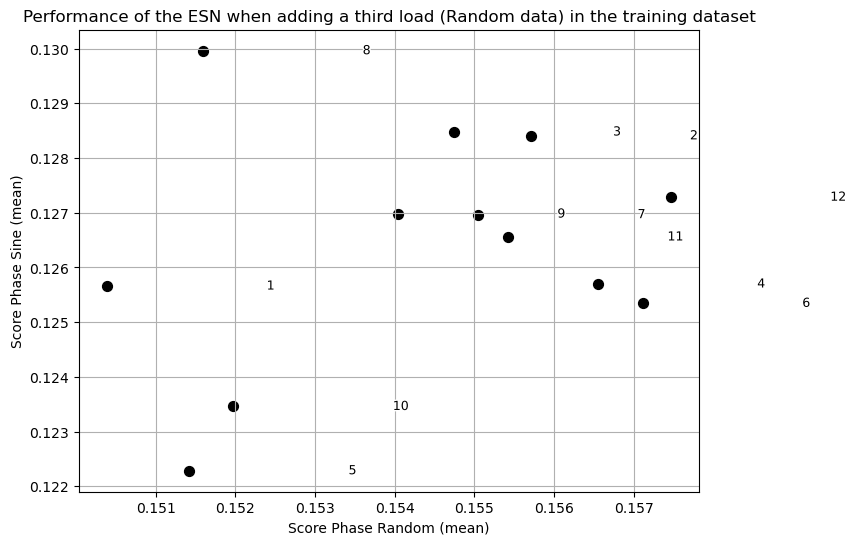

Config  lambda   rho  sparsity  inputScaling  reservoirScaling  \
0        1       1  0.95         1           2.5                 1   
1        2       1  0.95         1           2.5                 1   
2        3       1  0.95         1           2.5                 1   
3        4       1  0.95         1           2.5                 1   
4        5       1  0.95         1           2.5                 1   
5        6       1  0.95         1           2.5                 1   
6        7       1  0.95         1           2.5                 1   
7        8       1  0.95         1           2.5                 1   
8        9       1  0.95         1           2.5                 1   
9       10       1  0.95         1           2.5                 1   
10      11       1  0.95         1           2.5                 1   
11      12       1  0.95         1           2.5                 1   

    biasScaling  leaky  dim_esn  t_train  t_washout  
0          0.55      1      800       80         20  
1          0.55      1      850       80         20  
2          0.55      1      900       80         20  
3          0.55      1      950       80         20  
4          0.55      1     1000       80         20  
5          0.55      1     1050       80         20  
6          0.55      1     1100       80         20  
7          0.55      1     1150       80         20  
8          0.55      1     1200       80         20  
9          0.55      1     1250       80         20  
10         0.55      1     1300       80         20  
11         0.55      1     1500       80         20

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import pandas as pd
import matplotlib.patheffects as path_effects  # <-- ajout ici

if len(results) == 0:
    print("Aucun résultat disponible dans 'results'.")
else:
    fig, ax = plt.subplots(figsize=(8, 6))
    for i, (params, scoreR, scoreS) in enumerate(results):
        ax.scatter(scoreR, scoreS, s=50, color='black')
        txt = ax.text(scoreR + 0.002, scoreS, str(i+1), fontsize=9, ha='left', va='center')
        # Contour blanc autour du texte
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

    ax.set_title('Performance of the ESN when adding a third load (Random data) in the training dataset')
    ax.set_xlabel('Score Phase Random (mean)')
    ax.set_ylabel('Score Phase Sine (mean)')
    ax.grid(True)
    output_dir = "benchmarkLoads"
    os.makedirs(output_dir, exist_ok=True)  # crée le dossier s'il n'existe pas
    #plt.savefig(os.path.join(output_dir, "thirdLoad_random_data.pdf"), format='pdf', bbox_inches='tight')

    plt.show()

    # Tableau pandas
    param_keys = list(results[0][0].keys())
    rows = []
    for i, (params, _, _) in enumerate(results):
        row = {"Config": i+1}
        row.update(params)
        rows.append(row)

    df = pd.DataFrame(rows)
    display(df)
